0.08271335393847717


<IPython.core.display.Javascript object>


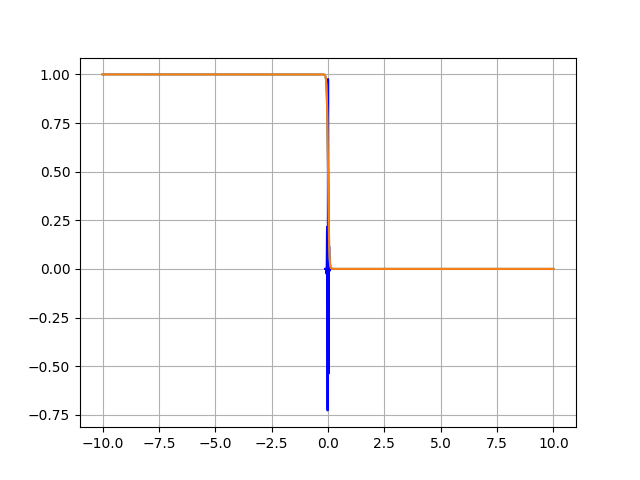

In [87]:
### Package implementing the formalism of Honeychurch et al, 2019
#author: jks
#v3: implemented FFT, and proper finite-difference differentiation

import numpy as np
from scipy.special import jv,jvp
import scipy as scipy
from numpy.polynomial.legendre import leggauss
from numpy.linalg import inv
from scipy.integrate import quad
#from numpy.polynomial.chebyshev import Chebyshev as cheb
from scipy.linalg import expm
#import numpy.polynomial.chebyshev
import math
import time
import PadeDecomp
from numba import njit, prange, jit
from scipy.interpolate import CubicSpline
#matrix structure of internal variables: #aux, aux , ... T, omega, [device space matrix]
import os, psutil
process = psutil.Process(os.getpid())
from scipy.signal import hilbert as scipy_hilbert
%matplotlib notebook

##print(process.memory_info().rss/2**30)  # in GB
class timescale:
    Gamma_L =0
    Gamma_R =0
    H = 0
    H_dT = 0
    mu_L = 0.0
    Temperature = 0
    mu_R = 0
    Delta_L = 0
    Delta_R = 0
    Delta = 0
    device_dim = 0

    #variables
    T = np.array([0]).reshape(-1,1,1,1)
    omega = np.array([0]).reshape(-1,1,1)
    omega_weights =np.array([0]).reshape(-1,1,1)

    tau = 0
    tau_weights = 0

    Vbias = lambda t:0
    Vbias_dT = lambda t:0

    #self-energies
    Sigma_R_less  = 0
    Sigma_L_less  = 0
    Sigma_L_R  = 0
    Sigma_L_A  = 0
    Sigma_R_R  = 0
    Sigma_R_A  = 0
    Sigma_L_less_dT  = 0
    Sigma_R_less_dT  = 0
    Sigma_L_R_dT  = 0
    Sigma_L_A_dT  = 0
    Sigma_R_R_dT  = 0
    Sigma_R_A_dT  = 0
    Sigma_L_less_dw  = 0
    Sigma_R_less_dw  = 0
    Sigma_L_R_dw  = 0
    Sigma_L_A_dw  = 0
    Sigma_R_R_dw  = 0
    Sigma_R_A_dw  = 0
    Sigma_R  = 0
    Sigma_A  = 0
    Sigma_less  = 0
    Sigma_less_dT  = 0
    Sigma_less_dw  = 0
    Sigma_R_dT  = 0
    Sigma_A_dT  = 0
    Sigma_R_dw = 0
    Sigma_A_dw = 0

    G0_R = 0
    G0_A = 0
    G0_less = 0 
    G0_R_dT = 0
    G0_R_dw = 0 
    G0_A_dT = 0
    G0_A_dw = 0 
    G0_less_dT = 0 
    G0_less_dw = 0 
    G1_R = 0 
    G1_A = 0
    G1_less = 0 

    expint_R = None
    expint_L = None

    def __init__(self,T=None,omega_params=None,Gamma_L=(lambda x : np.eye(2)),Gamma_R=(lambda x : np.eye(2)),H=None,
                 Temperature=0.1,mu_L = 0, mu_R = 0,Delta_L = 0, Delta_R = 0, Delta = 0,
                 Vbias=(lambda t : 0),Vbias_dT=None,Vbias_int=None,
                 use_aux_modes=False,Fermi_params=[],Lorentz_params_L=[],Lorentz_params_R=[],eta=None):
        #T: np.array of times
        #omega: list or nparray with syntax [omega_min, omega_max, N_omega]
        
        dev_dim = np.shape(Delta)[-1]
        self.device_dim = dev_dim
        self.Gamma_L = Gamma_L
        self.Gamma_R = Gamma_R
        if callable(Gamma_L):
            self.WBL_L = False
        else:
            self.WBL_L = True
        if callable(Gamma_R):
            self.WBL_R = False
        else:
            self.WBL_R = True

        self.Temperature = Temperature 
        self.mu_L = mu_L 
        self.mu_R = mu_R 
        self.Delta_L = Delta_L 
        self.Delta_R = Delta_R 
        self.Delta = Delta

        T=T.reshape(-1,1,1,1)
        self.T=T
        if H is not None:
            self.H = H + Delta*Vbias(T)
            self.f_H = lambda t : (H + Delta*Vbias(t))
        if Vbias_dT == None:
            if np.all(Delta == 0):
                Vbias_dT = lambda t : 0
            else:
                Vbias_dT = lambda t : self.FD(Vbias,t) #numerical derivative w/ finite difference
        self.H_dT = Delta*Vbias_dT(T)

        self.Vbias = Vbias
        self.Vbias_dT = Vbias_dT
        self.Vbias_int = Vbias_int
        self.use_aux_modes = use_aux_modes
        self.Fermi_params = Fermi_params
        self.Lorentz_params_L = Lorentz_params_L
        self.Lorentz_params_R = Lorentz_params_R


        if omega_params is not None: 
            omega_min, omega_max, N_omega = omega_params
            #omega, omega_weights = self.get_integration_var(N_omega,omega_min,omega_max)
            omega = np.linspace(omega_min,omega_max,N_omega)
            omega_weights = np.ones(N_omega)*(omega[1]-omega[0])
            omega_weights[0] = omega_weights[0]/2
            omega_weights[-1] = omega_weights[-1]/2
                #                     T, w  matrix
            self.omega = omega.reshape(1,-1,   1,1)
            self.omega_weights = omega_weights.reshape(1,-1,1,1)
            self.dw = (omega_max - omega_min)/(N_omega -1)
            if eta == None:
                eta = self.dw
            self.eta = eta



    def get_physical_params(self,Test): #Gets physical parameters (hamiltonian, chemical potentials, temperature, self-energy etc) from the TimedependentTransport object Test
        print('Running get_physical_params. Remember Delta_R, Delta_L, Delta and Vbias must be specified manually')
        Temperature_L, Temperature_R = Test.kT_i
        self.Temperature = Temperature_L
        if Temperature_L != Temperature_R:
            print('Error in get_physical_params: Electrodes must have same temperature')
            assert 1==0
            return
        if len(Test.kT_i) != 2:
            print('Error in get_physical_params: System must contain exactly 2 electrodes')
            assert 1==0
            return
        mu_L, mu_R = Test.mu_i
        self.mu_L = mu_L
        self.mu_R = mu_R
        self.H = Test.Hdense[0,0] + self.potential(self.T)
        self.device_dim = np.shape(self.H)[-1]
        self.f_H = lambda t : (Test.Hdense[0,0] + self.potential(t))


        if self.use_aux_modes:
            self.get_Lorentz_and_Fermi_params(Test)
        else: #get self-energy from TBTrans (stored in Test)
            sidx = Test.sampling_idx[0]
            TBT_Gam_sparse_L = Test.Nonortho_Gammas[0].get_e_subset(sidx)
            E  = Test.Contour[sidx]
            if len(E) == 1: #spline interpolation cannot be based on one point; use Lorentz instead
                print('Warning: only one point in contour. Using Lorentzian expansion of self energies.')
                self.get_Lorentz_and_Fermi_params(Test)
                return
            TBT_Gam_L = Test.bs2np(TBT_Gam_sparse_L)[0]
            self.coupling_index_L = (np.sum(np.abs(TBT_Gam_L),axis=0) != 0) #array of size nxn containing True if site n couples to left lead, and no if not.
            TBT_Gam_sparse_R = Test.Nonortho_Gammas[1].get_e_subset(sidx)
            TBT_Gam_R = Test.bs2np(TBT_Gam_sparse_R)[0]
            self.coupling_index_R = (np.sum(np.abs(TBT_Gam_R),axis=0) != 0) #array of size nxn containing True if site n couples to left lead, and no if not.
            def Gamma_L(eps,i=None,j=None):
                if i is None:
                    cs = CubicSpline(E.real,TBT_Gam_L,extrapolate=False)
                else: 
                    cs = CubicSpline(E.real,TBT_Gam_L[:,i,j],extrapolate=False)
                eps = eps.reshape(1,-1)
                res = cs(eps)
                if self.eta != 0:
                    res = res + self.eta*np.identity(res.shape)
                res[np.isnan(res)] = 0
                return res# + self.eta*self.coupling_index_L

            def Gamma_R(eps,i=None,j=None):
                if i is None:
                    cs = CubicSpline(E.real,TBT_Gam_R,extrapolate=False)
                else: 
                    cs = CubicSpline(E.real,TBT_Gam_R[:,i,j],extrapolate=False)
                cs = CubicSpline(E.real,TBT_Gam_R,extrapolate=False)
                eps = eps.reshape(1,-1)
                res = cs(eps)
                if self.eta != 0:
                    res = res + self.eta*np.identity(res.shape)
                res[np.isnan(res)] = 0
                return res# + self.eta*self.coupling_index_R

            self.Gamma_L = Gamma_L
            self.Gamma_R = Gamma_R




    def get_Lorentz_and_Fermi_params(self,Test): #Test is a TimeDependentTransport object
        Lorentz_L = Test.fitted_lorentzians[0]
        Lorentz_L_np = Test.bs2np(Lorentz_L)[0]
        self.coupling_index_L = (np.sum(np.abs(Lorentz_L_np),axis=0) != 0) #array of size nxn containing True if site n couples to left lead, and no if not.
        ei_L,wi_L = Lorentz_L.ei, Lorentz_L.gamma
        ei_L = ei_L.reshape(-1,1,1)
        wi_L = wi_L.reshape(-1,1,1)

        Lorentz_R = Test.fitted_lorentzians[1]
        Lorentz_R_np = Test.bs2np(Lorentz_R)[0]
        self.coupling_index_R = (np.sum(np.abs(Lorentz_R_np),axis=0) != 0) #array of size nxn containing True if site n couples to left lead, and no if not.
        ei_R,wi_R = Lorentz_R.ei, Lorentz_R.gamma
        ei_R = ei_R.reshape(-1,1,1)
        wi_R = wi_R.reshape(-1,1,1)

        Lorentz_poles_L = np.concatenate((ei_L + 1j*wi_L,ei_L - 1j*wi_L))
        Lorentz_ccoefs_L = np.concatenate((wi_L**2*Lorentz_L_np/(2j*wi_L),wi_L**2*Lorentz_L_np/(-2j*wi_L)))
        if self.eta != 0:
            #add extra, very wide Lorentzian to avoid numerical issues. 
            #currently the width is set to 100 times the frequency range, and is centered at the fermi energy
            W = 5*(self.omega.max() - self.omega.min())
            Wide_Lor_poles = np.array([0*self.mu_L + 1j*W, 0*self.mu_L - 1j*W]).reshape(-1,1,1)
            Wide_Lor_ccoefs = np.array([W*self.eta*self.coupling_index_L/(2j),W*self.eta*self.coupling_index_L/(-2j)])
            Lorentz_poles_L = np.concatenate((Lorentz_poles_L,Wide_Lor_poles))
            Lorentz_ccoefs_L = np.concatenate((Lorentz_ccoefs_L,Wide_Lor_ccoefs))
        self.Lorentz_params_L = (Lorentz_poles_L, Lorentz_ccoefs_L)

        Lorentz_poles_R = np.concatenate((ei_R + 1j*wi_R,ei_R - 1j*wi_R))
        Lorentz_ccoefs_R = np.concatenate((wi_R**2*Lorentz_R_np/(2j*wi_R),wi_R**2*Lorentz_R_np/(-2j*wi_R)))
        if self.eta != 0:
            #add extra, very wide Lorentzian to avoid numerical issues. 
            #currently the width is set to 100 times the frequency range, and is centered at the fermi energy
            W = 5*(self.omega.max() - self.omega.min())
            Wide_Lor_poles = np.array([0*self.mu_R + 1j*W, 0*self.mu_R - 1j*W]).reshape(-1,1,1)
            Wide_Lor_ccoefs = np.array([W*self.eta*self.coupling_index_R/(2j),W*self.eta*self.coupling_index_R/(-2j)])
            Lorentz_poles_R = np.concatenate((Lorentz_poles_R,Wide_Lor_poles))
            Lorentz_ccoefs_R = np.concatenate((Lorentz_ccoefs_R,Wide_Lor_ccoefs))
        self.Lorentz_params_R = (Lorentz_poles_R, Lorentz_ccoefs_R)


        def Gamma_L(eps,i=None,j=None):
            roots,complex_coefs = self.Lorentz_params_L
            if i is not None:
                complex_coefs = complex_coefs[:,i,j]
            NL = len(roots)
            res = 0
            for i in range(NL):
                res = res + complex_coefs[i]/(eps - roots[i])# - complex_coefs[i]/(eps - np.conjugate(roots[i]))
            res = res
            return res
        def Gamma_R(eps,i=None,j=None):
            roots,complex_coefs = self.Lorentz_params_R
            NL = len(roots)
            if i is not None:
                complex_coefs = complex_coefs[:,i,j]
            res = 0
            for i in range(NL):
                res = res + complex_coefs[i]/(eps - roots[i])# - complex_coefs[i]/(eps - np.conjugate(roots[i]))
            return res
        self.Gamma_L = Gamma_L
        self.Gamma_R = Gamma_R

        PDroots, PDcoefs = PadeDecomp.Hu_poles(Test.num_poles)
        PDroots = np.concatenate((PDroots,PDroots.conjugate())) #the function returns only roots w/ pos. imaginary part. 
        PDcoefs = np.concatenate((PDcoefs,PDcoefs))
        self.Fermi_params = (PDroots*self.Temperature, -PDcoefs*self.Temperature)
        #print('obtained Lorentz and fermi params',flush=True)



    def Fermi_pade(self,eps,alpha='L'):
        #eps=eps.reshape(-1,1)
        if alpha=='L':
            mu = self.mu_L
        elif alpha=='R':
            mu = self.mu_R
        else: 
            print('error in Fermi_pade: alpha must be specified')
            assert 1==0
        Fermi_poles, Fermi_res = self.Fermi_params
        res = 1/2
        for i in range(len(Fermi_poles)):
            res = res + Fermi_res[i]/(eps-mu-Fermi_poles[i])
        return res

    @staticmethod
    def exp(x): #exponential function that does not return inf for large input values
        if np.any(np.iscomplex(x)):
            if hasattr(x, '__iter__'):
                x[np.real(x)>709] = 709 + 1j*np.imag(x[np.real(x)>709])
                #x[x<-710]00 = - 710
            else: 
                x = 709 + 1j*np.imag(x) if np.real(x)>709 else x
                #1
                #x = -700 if x<-700 else x
        else:
            if hasattr(x, '__iter__'):
                x[x>709] = 709
                #x[x<-710]00 = - 710
            else: 
                x = 709 if x>709 else x
                #x = -700 if x<-700 else x
        return np.exp(x)

    @staticmethod
    def hilbert(f,axis=-1,padding_length=-1): #computes the hilbert transform of f along axis assuming zero boundary conditions
        shape = list(f.shape)
        f = f.real
        if padding_length == -1:
            padding_length = int(shape[axis]) #pads f with the same number of zeros as its length
            #print(padding_length)
        padding_indices = []
        for i in range(len(shape)):
            padding_indices.append((0,))
        padding_indices[axis]=(padding_length,)

        fpad = np.pad(f,padding_indices)
        #print(fpad.shape)
        hpad = scipy_hilbert(fpad,axis=axis).imag

        hpad = hpad.swapaxes(0,axis)

        h = hpad[padding_length:-padding_length] #remove padding

        h = h.swapaxes(0,axis)

        return h
    
    
    @staticmethod
    def get_integration_var(N_int,lower_lim = 0, upper_lim = 1):
        #function to get N_int gauss-legendre quadrature points and weights in the specified interval
        x,w = leggauss(N_int)
        x = (x + 1)/2*(upper_lim-lower_lim) + lower_lim
        w *= (upper_lim - lower_lim)/2
        return x,w

    def int_residues2(self,function, params,halfplane='upper'): 
        #version 2 - handles complex functions. however, now residues and poles in the lower half plane must be explicitly passed.
        # uses the residue theorem to calculate an integral from -infty to +infty of the function 'function(x) * g(x)'
        #where 'function' is assumed not to contain poles. it is assumed there are no poles on the real axis.
        #The function g(x) is specified in the form (poles, residues).
        poles, residues = params
        if not hasattr(poles, '__iter__'): #put poles in a list so the syntax of the following lines will work.
            poles = np.array(poles)
        if not hasattr(residues, '__iter__'):
            residues = np.array(residues)
        if np.any(poles.imag == 0):
            print('error in int_residues2: pole on real axis. saved list of poles as int_residues2_error_poles.npy',flush=True)
            np.save('int_residues2_error_poles',poles)
            assert 1==0
        if halfplane == 'upper':
            indices = np.imag(poles)>0
            poles = poles[indices]
            residues = residues[indices.flatten()]
        elif halfplane == 'lower': 
            indices = np.imag(poles)<0
            poles = poles[indices]
            residues = residues[indices.flatten()]
        else:
            print('error in int_residues2: half-plane improperly specified',flush=True)
            assert 1==0
        res = 0
        for i in range(len(poles)):
            res = res + function(poles[i]) * residues[i]
        res = res*1j*2*np.pi
        if halfplane =='lower':
            res = - res #switch sign to account for the contour having been traversed in the clockwise direction
        return res


    def fermi(self,eps,mu=0): #fermi-dirac distribution. 
        #return self.exp(-(eps-mu)/self.Temperature)/(1+self.exp(-(eps-mu)/self.Temperature))
        return 1/(1+self.exp((eps-mu)/self.Temperature))
    def f_L(self,eps):
        return self.fermi(eps,self.mu_L)
    def f_R(self,eps):
        return self.fermi(eps,self.mu_R)

    def potential_L(self,T): #Vbias is a function with syntax Vbias(T) that returns the relevant bias.
        bias = self.Vbias(T)
        return self.Delta_L*bias

    def potential_R(self,T):
        bias = self.Vbias(T)
        return self.Delta_R*bias

    def potential(self,T):
        bias = self.Vbias(T)
        return self.Delta*bias

    def potential_dT(self,T):
        bias_dT = self.Vbias_dT(T)
        return self.Delta*bias_dT

    def expint3(self,T,tau,alpha): #T is Nx1, tau is 1xM. alpha is a char specifying the left lead, right lead or central region.
        #Suppose the support of the pulse is contained in the interval [Tmin, Tmax].
        t0=time.time()

        #set the correct potential
        if alpha == 'L':
            pot=self.potential_L
        elif alpha =='R':
            pot = self.potential_R
        else:
            pot = self.potential
            #print('error in expint3: alpha not ==R or L. This should be specified at this point!')
            assert 1==0

        #check if a new calculation is necessary
        if np.array_equal(T,self.T) and np.array_equal(tau,self.tau):
            if alpha == 'L':
                if not np.all(self.expint_L==None):
                    #print('expint3: returning stored value, alpha == L')
                    return self.expint_L #return alreay calculated value; otherwise proceed.
            elif alpha=='R':
                if not np.all(self.expint_R==None):
                    #print('expint3: returning stored value, alpha == R')
                    return self.expint_R

        n_int=5
        x,w = self.get_integration_var(n_int)

        def int_gauss(f,tmin,tmax,N=n_int):
            t = tmin + x*(tmax-tmin)
            q = w*(tmax-tmin)
            res=0
            for i in range(N):
                res += f(t[i])*q[i]
            return res
        def antiderivative(t,t0=None): #integrates the function pot and gives the antiderivative evaluated as F(t) - F(t0)
            F=[]
            Fcum=0
            if t0 is None:
                t0 = t[0]
            for tt in t:
                Fcum += int_gauss(pot,t0,tt)
                F.append(Fcum)
                t0=tt
            F=np.array(F)
            return F
        T1=T.flatten()
        tau1=tau.flatten()
        F = np.zeros((np.size(T),np.size(tau)))
        for i, TT in enumerate(T1):
            #for every t, calc the integral with bounds T-tau/2 .. T+tau/2 for every value of tau.
            #this is done by calculating the antiderivative for every value of T+tau/2 and every value T-tau/2, then subtracting the two.
                tlist1 = TT+tau1/2
                tlist2 = TT-tau1/2
                F1 = antiderivative(tlist1)
                F2 = antiderivative(tlist2)
                t0_correction = 0
                if tlist1[0] != tlist2[0]: #t0 is not the same in the two derivatives, leading to constant offset. this should fix
                    t01 = tlist1[0]
                    t02 = tlist2[0]
                    t0_correction = quad(pot,t01,t02)[0] #integrate with scipy
                F[i]=F1-F2-t0_correction
        #print('calculated integral of Vbias in %.2f'%(time.time()-t0),flush=True)

        F=F.reshape(np.size(T),np.size(tau),1,1)
        if np.array_equal(T,self.T) and np.array_equal(tau,self.tau):
            if alpha == 'L':
                self.expint_L = F
                #print('setting self.expint_L = F')
            elif alpha=='R':
                self.expint_R = F
                #print('setting self.expint_R = F')
        return F


    @staticmethod #n'th order derivative, FD.
    def FD(f,x,n=1,dx=1e-4,args=(),order=3): #f a callable function
        if order <=n:
            order = n + 1 #at least n+1 points must be used to calculate n'th derivative
            order = order + (1-order %2) #an odd-number of points must be used to calculate the derivative
        fd = scipy.misc.derivative(f,x,dx,n,args=args,order=order)
        return fd



    @staticmethod
    def fft(array,axis=-1):
        #return np.fft.fft(array,axis)
        return np.fft.fft(array,axis=axis)

    @staticmethod
    def ifft(array,axis=-1):
        #return np.fft.ifft(array,axis)
        return np.fft.ifft(array,axis=axis)

    @staticmethod
    def fftfreq(n,d):
     #return np.fft.fftfreq(n,d)
        return np.fft.fftfreq(n,d)

    def calc_Sigma_less(self,T=None,omega=None,alpha='L',extension_length=200): #new one with aux modes
        if np.all(T==None):
            T=self.T
            #print('calc_Sigma_less: set T = self.T',flush=True)
        if np.all(omega==None):
            omega = self.omega
            set_self_tau = 1
        else: 
            set_self_tau = 0

        if alpha=='L':
            f = self.f_L
            Gamma = self.Gamma_L
            potential = self.potential_L
            Lorentz_params = self.Lorentz_params_L
            coupling_index = self.coupling_index_L
            Delta_alpha = self.Delta_L
        else:
            f = self.f_R
            Gamma = self.Gamma_R
            potential = self.potential_R
            Lorentz_params = self.Lorentz_params_R
            coupling_index = self.coupling_index_R
            Delta_alpha = self.Delta_R
        if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
            Gamma_mat = Gamma
            Gamma = lambda x : Gamma_mat
            #print('WBL! Gamma was not callable')

        T=np.array(T).reshape(-1,1,1,1)
        omega=np.array(omega).reshape(-1,1,1)   
        exp = np.exp
        omega_min = omega.min()
        omega_max = omega.max()
        dw = (omega_max - omega_min)/(np.size(omega)-1)
        #if extension_length < np.size(omega)/4:
        #    extension_length = int(np.size(omega)/4)
        #extend internal arrays by extension_length. this is useful if the specified range of integration does not include the entire support of the given functions.
        extension = dw*np.linspace(1,extension_length,extension_length)
        w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
        w=w.reshape(-1,1,1)
        #print('w[extension_length] == omega_min? w[ext_len]==', w[extension_length],'omega_min ==',omega_min)
        #dw_taumax = 2*np.(Tmax - Tmin)
        #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
        V_min = - V_max
        max_freq = V_max - V_min
        dtau_max = 1/(2*max_freq)
        min_domain_length = 2*np.pi/dtau_max
        domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
        N1 = np.ceil(domain_length/dw) 
        #tau_max_for_entire_domain = 2*(Tmax - Tmin)
        #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
        #N3=max(N1,N2)
        N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
        if N>1e5:
            print("N in calc_Sigma_less larger than 100k!")
        #x = domain_length/N * np.arange(N) #generate x variable for FFT.
        x = dw*np.arange(N)
        domain_length= x.max() * N/(N-1)
        x = x.reshape(1,-1,1,1) #shape to proper size
        dtau = 2*np.pi/domain_length
        tau = dtau*np.arange(N) #generate tau variable for FFT
        tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
        #calculate expint
        if self.Vbias_int is None:
            expint = np.exp(-1j*self.expint3(T,tau,alpha))
        else:
            expint = np.exp(-1j*Delta_alpha*(self.Vbias_int(T+tau/2) - self.Vbias_int(T-tau/2)))

        expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
        Sigma_less = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        omega_index = slice(extension_length,(np.size(omega)+extension_length))
        if not self.use_aux_modes:
            fermi = f(x+w.min())
            Gam = Gamma(x+w.min())

        for i in range(self.device_dim):
            for j in range(self.device_dim):
                if coupling_index[i,j]:
                    if self.use_aux_modes:
                        fermi_int_residues = lambda E : Gamma(E,i,j)*exp(-1j*(E)*tau)
                        Lorentz_int_residues = lambda E : self.Fermi_pade(E,alpha)*exp(-1j*(E)*tau)#f(E)*exp(-1j*(E)*taup)#

                        Lor_poles, Lor_res = Lorentz_params
                        Lorentz_params_ij = [Lor_poles,Lor_res[:,i,j]]
                        fermi_int = self.int_residues2(fermi_int_residues,self.Fermi_params,halfplane='lower')
                        Lorentz_int = self.int_residues2(Lorentz_int_residues,Lorentz_params_ij,halfplane='lower')
                        Sigma_less_forward = (fermi_int + Lorentz_int).reshape(1,-1)/(2*np.pi)
                        Sigma_less_forward = Sigma_less_forward * exp(1j*w.min()*tau[:,:,0,0])
                        Sigma_less_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)
                        fermi_residues_Sigzero = lambda E : Gamma(E,i,j)/(omega-E)
                        Lorentz_residues_Sigzero = lambda E : self.Fermi_pade(E,alpha)/(omega-E)
                        fermi_int_Sigzero = self.int_residues2(fermi_residues_Sigzero,self.Fermi_params,halfplane='lower').reshape(1,-1)
                        Lorentz_int_Sigzero = self.int_residues2(Lorentz_residues_Sigzero,Lorentz_params_ij,halfplane='lower').reshape(1,-1)
                        #fg = (self.Fermi_pade(omega,alpha)*Gamma(omega,i,j)).reshape(1,-1)
                        Hilbert_trans = (fermi_int_Sigzero + Lorentz_int_Sigzero) #- 1j*np.pi*fg

                        Sigma_zero = 2j*np.real(expPhi*(1j*Hilbert_trans)/(2*np.pi))

                        Sigma_less[:,:,i,j] = 2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
                        #Sigma_zero = np.real()
                    else:

                        #forward transform (energy integral)
                        integrand = Gam[:,:,i,j]*fermi[:,:,0,0]
                        #integrand[:,0] /= 2
                        #integrand[:,-1] /= 2
                        Sigma_less_forward = domain_length/(2*np.pi*N)*self.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #the last factor is only needed if the energy integral does not start at omega_min
                        #Sigma_less_forward[:,0] /= 2
                        #Sigma_less_forward[:,-1] /= 2
                        #backward transform (tau integral)
                        #Sigma_less_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi) * Sigma_less_forward,axis=1)
                        Sigma_less_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)
                        fg=Gam[:,omega_index,i,j]*fermi[:,omega_index,0,0]
                        Sigma_zero = 2j*np.real(expPhi*(fg/2 + 1j/2*self.hilbert(fg)))

                        #Sigma_less_backward += expPhi*Gam[:,:,i,j]*fermi[:,:,0,0]/2 #divide by 2 because next line multiplies by 2
                        #Sigma_less[:,:,i,j] = 2j * np.real(Sigma_less_backward[:,extension_length:(np.size(omega)+extension_length)])
                        Sigma_less[:,:,i,j] =   2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
            #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

        return Sigma_less# + 1j*self.eta*np.identity(self.device_dim)


    """
    def calc_Sigma_less(self,T=None,omega=None,alpha='L',extension_length=200): #new one w/o aux modes
        if np.all(T==None):
            T=self.T
            #print('calc_Sigma_less: set T = self.T',flush=True)
        if np.all(omega==None):
            omega = self.omega
            set_self_tau = 1
        else: 
            set_self_tau = 0

        if alpha=='L':
            f = self.f_L
            Gamma = self.Gamma_L
            potential = self.potential_L
            Lorentz_params = self.Lorentz_params_L
            coupling_index = self.coupling_index_L
            Delta_alpha = self.Delta_L
        else:
            f = self.f_R
            Gamma = self.Gamma_R
            potential = self.potential_R
            Lorentz_params = self.Lorentz_params_R
            coupling_index = self.coupling_index_R
            Delta_alpha = self.Delta_R
        if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
            Gamma_mat = Gamma
            Gamma = lambda x : Gamma_mat
            #print('WBL! Gamma was not callable')

        T=np.array(T).reshape(-1,1,1,1)
        omega=np.array(omega).reshape(-1,1,1)   
        exp = np.exp
        omega_min = omega.min()
        omega_max = omega.max()
        dw = (omega_max - omega_min)/(np.size(omega)-1)
        #if extension_length < np.size(omega)/4:
        #    extension_length = int(np.size(omega)/4)
        #extend internal arrays by extension_length. this is useful if the specified range of integration does not include the entire support of the given functions.
        extension = dw*np.linspace(1,extension_length,extension_length)
        w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
        w=w.reshape(-1,1,1)
        #print('w[extension_length] == omega_min? w[ext_len]==', w[extension_length],'omega_min ==',omega_min)
        #dw_taumax = 2*np.(Tmax - Tmin)
        #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
        V_min = - V_max
        max_freq = V_max - V_min
        dtau_max = 1/(2*max_freq)
        min_domain_length = 2*np.pi/dtau_max
        domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
        N1 = np.ceil(domain_length/dw) 
        #tau_max_for_entire_domain = 2*(Tmax - Tmin)
        #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
        #N3=max(N1,N2)
        N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
        if N>1e5:
            print("N in calc_Sigma_less larger than 100k!")
        #x = domain_length/N * np.arange(N) #generate x variable for FFT.
        x = dw*np.arange(N)
        domain_length= x.max() * N/(N-1)
        x = x.reshape(1,-1,1,1) #shape to proper size
        dtau = 2*np.pi/domain_length
        tau = dtau*np.arange(N) #generate tau variable for FFT
        tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
        #calculate expint
        if self.Vbias_int is None:
            expint = np.exp(-1j*self.expint3(T,tau,alpha))
        else:
            expint = np.exp(-1j*Delta_alpha*(self.Vbias_int(T+tau/2) - self.Vbias_int(T-tau/2)))
            expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
            Sigma_less = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
            #extension_length=100
            fermi = f(x+w.min())
            Gam = Gamma(x+w.min())
            omega_index = slice(extension_length,(np.size(omega)+extension_length))
            #expint = np.pad(expint,[(0,),(extension_length,),(0,),(0,)],'edge')
            for i in range(self.device_dim):
                for j in range(self.device_dim):
                    if coupling_index[i,j]:
                        #forward transform (energy integral)
                        integrand = Gam[:,:,i,j]*fermi[:,:,0,0]
                        #integrand[:,0] /= 2
                        #integrand[:,-1] /= 2
                        Sigma_less_forward = domain_length/(2*np.pi*N)*self.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #the last factor is only needed if the energy integral does not start at omega_min
                        #Sigma_less_forward[:,0] /= 2
                        #Sigma_less_forward[:,-1] /= 2
                        #backward transform (tau integral)
                        #Sigma_less_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi) * Sigma_less_forward,axis=1)
                        Sigma_less_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)
                        fg=Gam[:,omega_index,i,j]*fermi[:,omega_index,0,0]
                        Sigma_zero = 2j*np.real(expPhi*(fg/2 + 1j/2*self.hilbert(fg)))

                        #Sigma_less_backward += expPhi*Gam[:,:,i,j]*fermi[:,:,0,0]/2 #divide by 2 because next line multiplies by 2
                        #Sigma_less[:,:,i,j] = 2j * np.real(Sigma_less_backward[:,extension_length:(np.size(omega)+extension_length)])
                        Sigma_less[:,:,i,j] =   2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
            #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

            return Sigma_less# + 1j*self.eta*np.identity(self.device_dim)""


    
    def calc_Sigma_less(self,T=None,omega=None,alpha='L',extension_length=50): #old one
        if np.all(T==None):
            T=self.T
            #print('calc_Sigma_less: set T = self.T',flush=True)
        if np.all(omega==None):
            omega = self.omega
            set_self_tau = 1
        else: 
            set_self_tau = 0
        T=np.array(T).reshape(-1,1,1,1)
        omega=np.array(omega).reshape(-1,1,1)   
        exp = np.exp
        omega_min = omega.min()
        omega_max = omega.max()
        N = np.size(omega)
        if extension_length < N/4:
            extension_length = int(N/4)
        #print('extending internal arrays by ',extension_length)
        dw = (omega_max - omega_min)/(np.size(omega)-1)
        dnu = dw/(2*np.pi)
        extension = dw*np.linspace(1,extension_length,extension_length)
        w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
        w = w.reshape(1,-1,1,1)
        tau = self.fftfreq(np.size(w),d=dnu).reshape(1,-1,1,1) #shape: T, tau, n, n
        if set_self_tau:
            self.tau = tau
        dtau = (np.max(tau)-np.min(tau))/(np.size(tau)-1)
        if alpha=='L':
            f = self.f_L
            Gamma = self.Gamma_L
            potential = self.potential_L
            Lorentz_params = self.Lorentz_params_L
            coupling_index = self.coupling_index_L
            Delta_alpha = self.Delta_L
        else:
            f = self.f_R
            Gamma = self.Gamma_R
            potential = self.potential_R
            Lorentz_params = self.Lorentz_params_R
            coupling_index = self.coupling_index_R
            Delta_alpha = self.Delta_R
        if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
            Gamma_mat = Gamma
            Gamma = lambda x : Gamma_mat
            #print('WBL! Gamma was not callable')


        t0=time.time()
        if self.Vbias_int is None:
            expint = np.exp(-1j*self.expint3(T,tau,alpha))
        else:
            expint = np.exp(-1j*Delta_alpha*(self.Vbias_int(T+tau/2) - self.Vbias_int(T-tau/2)))

        if self.use_aux_modes:
            #print('warning! aux modes not yet implemented in v3')
            #assert 1==0
            taup = tau[tau>=0].reshape(1,-1,1,1)
            taum = tau[tau<0].reshape(1,-1,1,1)
            fermi_res_lower = lambda E : Gamma(E)*exp(-1j*(E)*taup)
            Lorentz_res_lower = lambda E : self.Fermi_pade(E,alpha)*exp(-1j*(E)*taup)#f(E)*exp(-1j*(E)*taup)#

            fermi_res_upper = lambda E : Gamma(E)*exp(-1j*(E)*taum)
            Lorentz_res_upper = lambda E : self.Fermi_pade(E,alpha)*exp(-1j*(E)*taum) #f(E)*exp(-1j*(E)*taum)#

            fermi_int_lower = self.int_residues2(fermi_res_lower,self.Fermi_params,halfplane='lower')
            Lorentz_int_lower = self.int_residues2(Lorentz_res_lower,Lorentz_params,halfplane='lower')
            integral_lower = fermi_int_lower + Lorentz_int_lower

            fermi_int_upper = self.int_residues2(fermi_res_upper,self.Fermi_params,halfplane='upper')
            Lorentz_int_upper = self.int_residues2(Lorentz_res_upper,Lorentz_params,halfplane='upper')
            integral_upper = fermi_int_upper + Lorentz_int_upper
            
            Sigma_less_integrand = np.concatenate((integral_upper,integral_lower),axis=1)/(2*np.pi)
            alternate =2*(np.linspace(1,np.size(tau),np.size(tau)).reshape(1,-1,1,1) %2) - 1 #array of 1,-1,1,-1,..etc
            Sigma_less_integrand = np.size(w)*dtau*Sigma_less_integrand * alternate #see https://math.stackexchange.com/questions/688113/approximating-the-fourier-transform-with-dft-fft
            Sigma_less = 1j*self.ifft(expint*Sigma_less_integrand,axis=1)

            t1=time.time()
            #print('sigma_less: using aux mode! Got residues in %.2f'%(t1-t0),flush=True)
        else:
            Sigma_less = np.zeros((len(T),np.size(w),self.device_dim,self.device_dim),dtype=np.complex128)
            fermi = f(w)
            Gam = Gamma(w)
            for i in range(self.device_dim):
                for j in range(self.device_dim):
                    if coupling_index[i,j]:
                        Sigma_less_integrand=self.fft(Gam[:,:,i,j]*fermi[:,:,0,0],axis=1)
                        Sigma_less[:,:,i,j] = 1j*self.ifft(expint[:,:,0,0]*Sigma_less_integrand,axis=1)
            t1=time.time()
            #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

        #Sigma_less = 1j*self.ifft(expint*Sigma_less_integrand,axis=1)
        Sigma_less = Sigma_less[:,extension_length:-extension_length]

        return Sigma_less
    
    """
    def calc_Sigma_R(self,T=None,omega=None,alpha='L',extension_length=300): #new one
        if np.all(T==None):
            T=self.T
            #print('calc_Sigma_less: set T = self.T',flush=True)
        if np.all(omega==None):
            omega = self.omega
            set_self_tau = 1
        else: 
            set_self_tau = 0

        if alpha=='L':
            Gamma = self.Gamma_L
            potential = self.potential_L
            Lorentz_params = self.Lorentz_params_L
            coupling_index = self.coupling_index_L
            Delta_alpha = self.Delta_L
        else:
            Gamma = self.Gamma_R
            potential = self.potential_R
            Lorentz_params = self.Lorentz_params_R
            coupling_index = self.coupling_index_R
            Delta_alpha = self.Delta_R
        if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
            Gamma_mat = Gamma
            Gamma = lambda x : Gamma_mat
            #print('WBL! Gamma was not callable')

        T=np.array(T).reshape(-1,1,1,1)
        omega=np.array(omega).reshape(-1,1,1)   
        exp = np.exp
        omega_min = omega.min()
        omega_max = omega.max()
        dw = (omega_max - omega_min)/(np.size(omega)-1)
        #extension_length = 50
        #if extension_length < np.size(omega)/4:
        #    extension_length = int(np.size(omega)/4)
        #print('extending internal arrays by ',extension_length)
        extension = dw*np.linspace(1,extension_length,extension_length)
        w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
        w=w.reshape(-1,1,1)
        if np.array_equal(w,omega):
            print('w==omega, extension_length ==', extension_length)

        #w=omega
        #dw_taumax = 2*np.(Tmax - Tmin)
        #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
        V_min = - V_max
        max_freq = V_max - V_min
        dtau_max = 1/(2*max_freq)
        min_domain_length = 2*np.pi/dtau_max
        domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
        N1 = np.ceil(domain_length/dw) 
        #tau_max_for_entire_domain = 2*(Tmax - Tmin)
        #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
        #N3=max(N1,N2)
        N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
        #x = domain_length/N * np.arange(N) #generate x variable for FFT.
        x = dw*np.arange(N)
        x = x.reshape(1,-1,1,1) #shape to proper size
        domain_length = x.max() * N/(N-1)
        dtau = 2*np.pi/domain_length
        tau = dtau*np.arange(N) #generate tau variable for FFT
        tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
        #calculate expint
        if self.Vbias_int is None:
            expint = np.exp(-1j*self.expint3(T,tau,alpha))
        else:
            expint = np.exp(-1j*Delta_alpha*(self.Vbias_int(T+tau/2) - self.Vbias_int(T-tau/2)))
        expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
        Sigma_R = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        #extension_length=100
        if not self.use_aux_modes:
            Gam = Gamma(x+w.min())
        omega_index = slice(extension_length,(np.size(omega)+extension_length))
        for i in range(self.device_dim):
            for j in range(self.device_dim):
                if coupling_index[i,j]:
                    if self.use_aux_modes:
                        Lorentz_int_residues = lambda E : exp(-1j*(E)*tau)#f(E)*exp(-1j*(E)*taup)#
                        Lor_poles, Lor_res = Lorentz_params
                        Lorentz_params_ij = [Lor_poles,Lor_res[:,i,j]]
                        Lorentz_int = self.int_residues2(Lorentz_int_residues,Lorentz_params_ij,halfplane='lower')
                        Sigma_R_forward = Lorentz_int.reshape(1,-1)/(2*np.pi)
                        Sigma_R_forward = Sigma_R_forward * exp(1j*w.min()*tau[:,:,0,0])
                        #Sigma_R_forward[:,0] /= 2
                        #Sigma_R_forward[:,-1] /= 2
                        Sigma_R_backward = -1j*tau.max() * self.ifft((expint[:,:,0,0]-expPhi)* Sigma_R_forward,axis=1)
                        Lorentz_residues_Sigzero = lambda E : 1/(omega-E)
                        Hilbert_trans = self.int_residues2(Lorentz_residues_Sigzero,Lorentz_params_ij,halfplane='lower').reshape(1,-1)
                        Sigma_zero = -1j*expPhi*(0*Gamma(omega,i,j).reshape(1,-1)/2 + 1j*Hilbert_trans/(2*np.pi) ).reshape(1,-1)
                        Sigma_R[:,:,i,j] =  Sigma_R_backward[:,omega_index] +Sigma_zero
                    else:
                    #forward transform (energy integral)
                        integrand = Gam[:,:,i,j]
                        #integrand[:,0] /= 2
                        #integrand[:,-1] /= 2
                        Sigma_R_forward = domain_length/(2*np.pi*N)*self.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #this factor is only needed if the energy integral does not start at omega_min
                        #Sigma_R_forward[:,0] /= 2
                        #Sigma_R_forward[:,-1] /= 2
                        #backward transform (tau integral)
                        Sigma_R_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi) * Sigma_R_forward,axis=1)

                        Sigma_R_backward = -1j*Sigma_R_backward[:,omega_index]
                        #print('Sigma_R_backward_shape',Sigma_R_backward.shape)
                        Sigma_R[:,:,i,j] =   Sigma_R_backward - expPhi*(1j*Gam[:,omega_index,i,j]/2 - 1/2*self.hilbert(Gam[:,omega_index,i,j],axis=1))#
        #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

        #Sigma_less = 1j*self.ifft(expint*Sigma_less_integrand,axis=1)
        #Sigma_less = Sigma_less[:,extension_length:-extension_length]
        return Sigma_R
    """

    def calc_Sigma_R(self,T=None,omega=None,alpha='L',extension_length=1000): #new one
        if np.all(T==None):
            T=self.T
            #print('calc_Sigma_less: set T = self.T',flush=True)
        if np.all(omega==None):
            omega = self.omega
            set_self_tau = 1
        else: 
            set_self_tau = 0

        if alpha=='L':
            Gamma = self.Gamma_L
            potential = self.potential_L
            Lorentz_params = self.Lorentz_params_L
            coupling_index = self.coupling_index_L
            Delta_alpha = self.Delta_L
        else:
            Gamma = self.Gamma_R
            potential = self.potential_R
            Lorentz_params = self.Lorentz_params_R
            coupling_index = self.coupling_index_R
            Delta_alpha = self.Delta_R
        if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
            Gamma_mat = Gamma
            Gamma = lambda x : Gamma_mat
            #print('WBL! Gamma was not callable')

        T=np.array(T).reshape(-1,1,1,1)
        omega=np.array(omega).reshape(-1,1,1)   
        exp = np.exp
        omega_min = omega.min()
        omega_max = omega.max()
        dw = (omega_max - omega_min)/(np.size(omega)-1)
        #extension_length = 50
        #if extension_length < np.size(omega)/4:
        #    extension_length = int(np.size(omega)/4)
        #print('extending internal arrays by ',extension_length)
        extension = dw*np.linspace(1,extension_length,extension_length)
        w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
        w=w.reshape(-1,1,1)
        if np.array_equal(w,omega):
            print('w==omega, extension_length ==', extension_length)

        #w=omega
        #dw_taumax = 2*np.(Tmax - Tmin)
        #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
        V_min = - V_max
        max_freq = V_max - V_min
        dtau_max = 1/(2*max_freq)
        min_domain_length = 2*np.pi/dtau_max
        domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
        N1 = np.ceil(domain_length/dw) 
        #tau_max_for_entire_domain = 2*(Tmax - Tmin)
        #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
        #N3=max(N1,N2)
        N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
        #x = domain_length/N * np.arange(N) #generate x variable for FFT.
        x = dw*np.arange(N)
        x = x.reshape(1,-1,1,1) #shape to proper size
        dtau = 2*np.pi/domain_length
        tau = dtau*np.arange(N) #generate tau variable for FFT
        tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
        #calculate expint
        if self.Vbias_int is None:
            expint = np.exp(-1j*self.expint3(T,tau,alpha))
        else:
            expint = np.exp(-1j*Delta_alpha*(self.Vbias_int(T+tau/2) - self.Vbias_int(T-tau/2)))
            expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
            Sigma_R = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
            #extension_length=100
            Gam = Gamma(x+w.min())
            #expint = np.pad(expint,[(0,),(extension_length,),(0,),(0,)],'edge')
            omega_index = slice(extension_length,(np.size(omega)+extension_length))
            for i in range(self.device_dim):
                for j in range(self.device_dim):
                    if coupling_index[i,j]:
                        #forward transform (energy integral)
                        integrand = Gam[:,:,i,j]
                        integrand[:,0] /= 2
                        integrand[:,-1] /= 2
                        Sigma_R_forward = domain_length/(2*np.pi*N)*self.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #this factor is only needed if the energy integral does not start at omega_min
                        Sigma_R_forward[:,0] /= 2
                        Sigma_R_forward[:,-1] /= 2
                        #backward transform (tau integral)
                        Sigma_R_backward = tau.max() * self.ifft((expint[:,:,0,0]-expPhi) * Sigma_R_forward,axis=1)
                
                        Sigma_R_backward = -1j*Sigma_R_backward[:,omega_index]
                        #print('Sigma_R_backward_shape',Sigma_R_backward.shape)
                        Sigma_R[:,:,i,j] =   Sigma_R_backward - expPhi*(1j*Gam[:,omega_index,i,j]/2 - 1/2*self.hilbert(Gam[:,omega_index,i,j],axis=1))
            #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

        #Sigma_less = 1j*self.ifft(expint*Sigma_less_integrand,axis=1)
        #Sigma_less = Sigma_less[:,extension_length:-extension_length]
        return Sigma_R #- 1j*self.eta*np.identity(self.device_dim)

    
    
    def calc_Sigma_R(self,T=None,omega=None,alpha='L',extension_length=50): #old one
        if np.all(T==None):
            T=self.T
            #print('calc_Sigma_R: set T = self.T',flush=True)
        if np.all(omega==None):
            omega = self.omega
            set_self_tau = 1
        else: 
            set_self_tau = 0
        T=np.array(T).reshape(-1,1,1,1)
        omega=np.array(omega).reshape(-1,1,1)   
        exp = np.exp
        omega_min = omega.min()
        omega_max = omega.max()
        N = np.size(omega)
        if extension_length < N/4:
            extension_length = int(N/4)
        #print('extending internal arrays by ',extension_length)
        dw = (omega_max - omega_min)/(np.size(omega)-1)
        dnu = dw/(2*np.pi)
        extension = dw*np.linspace(1,extension_length,extension_length)
        w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
        w = w.reshape(1,-1,1,1)
        tau = self.fftfreq(np.size(w),d=dnu).reshape(1,-1,1,1) #shape: T, tau, n, n
        if set_self_tau:
            self.tau = tau
        dtau = (np.max(tau)-np.min(tau))/(np.size(tau)-1)
        if alpha=='L':
            Gamma = self.Gamma_L
            potential = self.potential_L
            Lorentz_params = self.Lorentz_params_L
            coupling_index=self.coupling_index_L
            Delta_alpha = self.Delta_L
        else:
            Gamma = self.Gamma_R
            potential = self.potential_R
            Lorentz_params = self.Lorentz_params_R
            coupling_index=self.coupling_index_R
            Delta_alpha = self.Delta_R
        if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
            Gamma_mat = Gamma
            Gamma = lambda x : Gamma_mat
            #print('WBL! Gamma was not callable')


        t0=time.time()
        if self.Vbias_int is None:
            expint = np.exp(-1j*self.expint3(T,tau,alpha))
        else:
            expint = np.exp(-1j*Delta_alpha*(self.Vbias_int(T+tau/2) - self.Vbias_int(T-tau/2)))

        if self.use_aux_modes:
            #print('error! aux modes not yet implemented in v3')
            #assert 1==0
            taup = tau[tau>0].reshape(1,-1,1,1)
            taum = tau[tau<0].reshape(1,-1,1,1)
            Lorentz_res_lower = lambda E : exp(-1j*(E)*taup)#f(E)*exp(-1j*(E)*taup)#

            integral_lower = self.int_residues2(Lorentz_res_lower,Lorentz_params,halfplane='lower')
            integral_upper = np.zeros(np.shape(integral_lower))

            if np.any(tau ==0):
                integral_zero = np.sum(Gamma(w),axis=1).reshape(1,1,self.device_dim,self.device_dim)*dw/2 #factor one half comes from the approximation that theta(0) = 1/2 !
                Sigma_R_integrand = np.concatenate((integral_upper,integral_zero,integral_lower),axis=1)/(2*np.pi)
            else:
                Sigma_R_integrand = np.concatenate((integral_upper,integral_lower),axis=1)/(2*np.pi)
            alternate =2*(np.linspace(1,np.size(tau),np.size(tau)).reshape(1,-1,1,1) %2) - 1 #array of 1,-1,1,-1,..etc
            Sigma_R_integrand = np.size(w)*dtau*Sigma_R_integrand * alternate #see https://math.stackexchange.com/questions/688113/approximating-the-fourier-transform-with-dft-fft
            theta = np.zeros(np.shape(tau))
            theta[tau>0] = 1
            theta[tau == 0] = 1/2
            Sigma_R = -1j*self.ifft(theta*expint*Sigma_R_integrand,axis=1)
            t1=time.time()
            #print('sigma_R: using aux mode! Got residues in %.2f'%(t1-t0),flush=True)
        else:
            Sigma_R = np.zeros((len(T),np.size(w),self.device_dim,self.device_dim),dtype=np.complex128)
            Gam = Gamma(w)
            theta = np.zeros(np.shape(tau))
            theta[tau>0] = 1
            theta[tau == 0] = 1/2
            for i in range(self.device_dim):
                for j in range(self.device_dim):
                    if coupling_index[i,j]:
                        Sigma_R_integrand=self.fft(Gam[:,:,i,j],axis=1)
                        Sigma_R[:,:,i,j] = -1j*self.ifft(theta[:,:,0,0]*expint[:,:,0,0]*Sigma_R_integrand,axis=1)


            t1=time.time()
            #print('sigma_R: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

        #Sigma_R = -1j*self.ifft(expint*Sigma_R_integrand,axis=1)
        Sigma_R = Sigma_R[:,extension_length:-extension_length]

        return Sigma_R
    
    """
    
    def calc_Sigma(self,T=None,omega=None):
        if T is None:
            T = self.T
        if omega is None:
            omega = self.omega

        if self.WBL_R:
            Sigma_R_R = -1j*np.ones(np.shape(T*omega))*self.Gamma_R/2
            #print('calculated sigma_R_R in the WBL',flush=True)
        else:
            Sigma_R_R = self.calc_Sigma_R(T,omega,alpha='R')
        if self.WBL_L:
            Sigma_L_R = -1j*np.ones(np.shape(T*omega))*self.Gamma_L/2
            #print('calculated sigma_L_R in the WBL',flush=True)
        else:
            Sigma_L_R = self.calc_Sigma_R(T,omega,alpha='L')
        Sigma_L_less = self.calc_Sigma_less(T,omega,alpha='L')
        Sigma_R_less = self.calc_Sigma_less(T,omega,alpha='R')
        Sigma_L_A = np.conjugate(Sigma_L_R)
        Sigma_R_A = np.conjugate(Sigma_R_R)

        #Total self energies
        Sigma_R = Sigma_R_R + Sigma_L_R
        Sigma_A = Sigma_R_A + Sigma_L_A
        Sigma_less = Sigma_L_less + Sigma_R_less

        self.Sigma_R_less  = Sigma_R_less  
        self.Sigma_L_less  = Sigma_L_less  
        self.Sigma_L_R  = Sigma_L_R  
        self.Sigma_L_A  = Sigma_L_A  
        self.Sigma_R_R  = Sigma_R_R  
        self.Sigma_R_A  = Sigma_R_A  
        self.Sigma_R  = Sigma_R  
        self.Sigma_A  = Sigma_A  
        self.Sigma_less  = Sigma_less  
        
        return [Sigma_L_R,Sigma_R_R,Sigma_L_less,Sigma_R_less]




    def calc_density(self):
        if np.all(self.G0_less==0):
            self.calc_current()
        density = np.sum(self.omega_weights*np.imag(self.G0_less+self.G1_less),axis=1)/(2*np.pi)
        return density


    def calc_current(self,T=None,omega=None,side='left'):
        deriv = self.FD
        if T is None:
            T = self.T
        if omega is None:
            omega = self.omega
            omega_weights = self.omega_weightsd
        else:
            w=omega.flatten()
            omega_weights = (w[1:] - w[:-1]) #calculate dw
            omega_weights[0] = omega_weights[0]/2 #trapez: divide first weight by 2
            omega_weights = list(omega_weights)
            omega_weights.append(omega_weights[-1]/2)
            omega_weights = np.array(omega_weights).reshape(np.shape(omega))
        f_Sigma_L_R = lambda t : self.calc_Sigma_R(t,omega,alpha='L')
        f_Sigma_R_R = lambda t : self.calc_Sigma_R(t,omega,alpha='R')
        f_Sigma_L_less = lambda t : self.calc_Sigma_less(t,omega,alpha='L')
        f_Sigma_R_less = lambda t : self.calc_Sigma_less(t,omega,alpha='R')
        J0_L = np.zeros(len(T))
        J1_L = np.zeros(len(T))
        J0_R = np.zeros(len(T))
        J1_R = np.zeros(len(T))
        G0_less_array = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        G0_R_array = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        G1_less_array = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        G1_R_array = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        Pi0_L_array = np.zeros((np.size(T),np.size(omega),self.device_dim,self.device_dim),dtype=np.complex128)
        for i in range(len(T)):
            print('loop %d/%d'%(i+1,len(T)),flush=True)
            t=T[i].reshape(1,1,1,1)
            Sigma_L_R = f_Sigma_L_R(t)
            Sigma_R_R = f_Sigma_R_R(t)
            Sigma_L_less = f_Sigma_L_less(t)
            Sigma_R_less = f_Sigma_R_less(t)

            Sigma_L_A = np.conjugate(Sigma_L_R)
            Sigma_R_A = np.conjugate(Sigma_R_R)
            Sigma_R = Sigma_R_R + Sigma_L_R
            Sigma_A = Sigma_R_A + Sigma_L_A
            Sigma_less = Sigma_L_less + Sigma_R_less

            Sigma_L_less_dT = deriv(f_Sigma_L_less ,t)
            Sigma_R_less_dT = deriv(f_Sigma_R_less ,t)
            Sigma_L_R_dT = deriv(f_Sigma_L_R ,t)
            Sigma_R_R_dT = deriv(f_Sigma_R_R ,t)

            Sigma_L_A_dT = np.conjugate(Sigma_L_R_dT)
            Sigma_R_A_dT = np.conjugate(Sigma_R_R_dT)

            #functions to calculate derivatives wrt omega
            fw_Sigma_L_R = lambda w : self.calc_Sigma_R(t,w,alpha='L')
            fw_Sigma_R_R = lambda w : self.calc_Sigma_R(t,w,alpha='R')
            fw_Sigma_L_less = lambda w : self.calc_Sigma_less(t,w,alpha='L')
            fw_Sigma_R_less = lambda w : self.calc_Sigma_less(t,w,alpha='R')

            Sigma_L_less_dw = deriv(fw_Sigma_L_less ,omega,dx=1e-6)
            Sigma_R_less_dw = deriv(fw_Sigma_R_less ,omega,dx=1e-6)
            Sigma_L_R_dw = deriv(fw_Sigma_L_R ,omega,dx=1e-6)
            Sigma_R_R_dw = deriv(fw_Sigma_R_R ,omega,dx=1e-6)
            
            Sigma_L_A_dw = np.conjugate(Sigma_L_R_dw)
            Sigma_R_A_dw = np.conjugate(Sigma_R_R_dw)

            #Total self energies
            Sigma_less_dT = Sigma_L_less_dT + Sigma_R_less_dT
            Sigma_less_dw = Sigma_L_less_dw + Sigma_R_less_dw

            Sigma_R_dT =  Sigma_R_R_dT + Sigma_L_R_dT
            Sigma_A_dT =  Sigma_R_A_dT + Sigma_L_A_dT
            Sigma_R_dw=  Sigma_R_R_dw + Sigma_L_R_dw
            Sigma_A_dw=  Sigma_R_A_dw + Sigma_L_A_dw
            #print('Calculated derivatives',flush=True)


            H =  self.H[i]
            H_dT = self.H_dT[i]


            G0_R = inv(omega*np.identity(self.device_dim) - H - Sigma_R)
            G0_R_array[i] = G0_R
            G0_A = np.conjugate(G0_R)
            G0_less = G0_R@Sigma_less@G0_A
            G0_less_array[i] = G0_less
            #G0_great = G0_R - G0_A + G0_less

            #print('calculated G0',flush=True)
            #Current matrices - zero order. Eq (35)
            Pi0_L = G0_less@Sigma_L_A + G0_R@Sigma_L_less
            Pi0_L_array[i] = Pi0_L

            #The integral over omega is calculated as the vector product with the gauss-legendre weights. Eq (34)
            J0_L[i] = 1/np.pi * np.sum(np.trace(np.real(Pi0_L)*omega_weights,axis1=2,axis2=3),axis=1)


            #del(Pi0_L)
            Pi0_R = G0_less@Sigma_R_A + G0_R@Sigma_R_less
            J0_R[i] = 1/np.pi * np.sum(np.trace(np.real(Pi0_R)*omega_weights,axis1=2,axis2=3),axis=1)
            #del(Pi0_R)
            #print('calculated J0',flush=True)
            #FIRST ORDER

            #green function derivatives. Eqs (30), (29), (31)
            G0_R_dT = G0_R @ (H_dT+Sigma_R_dT)@G0_R
            G0_A_dT = np.conjugate(G0_R_dT)

            G0_R_dw = -G0_R@G0_R + G0_R@Sigma_R_dw@G0_R 
            G0_A_dw = np.conjugate(G0_R_dw)

            G0_less_dT = G0_R_dT@Sigma_less@G0_A + G0_R@Sigma_less@G0_A_dT + G0_R@Sigma_less_dT@G0_A
            G0_less_dw = G0_R_dw@Sigma_less@G0_A + G0_R@Sigma_less@G0_A_dw + G0_R@Sigma_less_dw@G0_A

            #First order green functions. Eqs (28) and (32)
            G1_R =  1j/2 * G0_R @  (-G0_R_dT - H_dT@G0_R_dw - Sigma_R_dT@G0_R_dw + Sigma_R_dw @ G0_R_dT)
            G1_R_array[i] = G1_R
            G1_A =  1j/2 * G0_A @  (-G0_A_dT - H_dT@G0_A_dw - Sigma_A_dT@G0_A_dw + Sigma_A_dw @ G0_A_dT)

            G1_less = G0_R@Sigma_less@G1_A + 1j/2*G0_R@(
                        -G0_less_dT - H_dT @ G0_less_dw - Sigma_less_dT@G0_A_dw + Sigma_less_dw@G0_A_dT - Sigma_R_dT@G0_less_dw + Sigma_R_dw@G0_less_dT
                        )
            G1_less_array[i] = G1_less
            #print('calculated G1',flush=True)
            #First order current matrices
            Pi1_L = G1_less@Sigma_L_A + G1_R@Sigma_L_less - 1j/2 * G0_less_dT@Sigma_L_A_dw + 1j/2*G0_less_dw@Sigma_L_A_dT -1j/2*G0_R_dT@Sigma_L_less_dw + 1j/2*G0_R_dw@Sigma_L_less_dT
            J1_L[i] = 1/np.pi * np.sum(np.trace(np.real(Pi1_L)*omega_weights,axis1=2,axis2=3),axis=1)
            #del(Pi1_L)
            Pi1_R = G1_less@Sigma_R_A + G1_R@Sigma_R_less - 1j/2 * G0_less_dT@Sigma_R_A_dw + 1j/2*G0_less_dw@Sigma_R_A_dT -1j/2*G0_R_dT@Sigma_R_less_dw + 1j/2*G0_R_dw@Sigma_R_less_dT
            J1_R[i] = 1/np.pi * np.sum(np.trace(np.real(Pi1_R)*omega_weights,axis1=2,axis2=3),axis=1)
        self.G0_R = G0_R_array
        self.G0_less = G0_less_array
        self.G1_R = G1_R_array
        self.G1_less = G1_less_array
        self.Pi0_L = Pi0_L_array
        if side =='left': 
            return J0_L, J1_L
        elif side=='right':
            return J0_R, J1_R
        elif side=='both':
            return [J0_L,J1_L],[J0_R,J1_R]


####################################### end class

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv,jvp
from numpy.polynomial.legendre import leggauss
import sisl
from TimedependentTransport.TimedependentTransport import TD_Transport, AdaptiveRK4
from scipy.special import erf
#print(erf(1))
#import sys
#sys.path.append('/home/jakob/Dropbox/DTU/Thesis/Simulations/Python')
#from honeychurch_v2 import timescale
#import sympy as sym
import scipy.constants


#Set physical parameters
to_pseconds = scipy.constants.hbar / scipy.constants.e * 1e12
to_THz = 1/to_pseconds
omega_to_THz = 1/(2*np.pi)*to_THz
Gamma = 1
#Gamma_L = 1/2
#Gamma_R = 1/2
Delta_L = 0
Delta_R = 0.125
Delta = np.array([[1,0],[0,1]])
epsilon = np.array([[0,0],[0,0]])
mu_L = 0
mu_R = 0

Omega = 20/omega_to_THz
print(Omega)
Temperature= 0.025
V_max = 1
#exp = 1
freq = 20/to_THz
zeta = 1/40 / to_pseconds
phi=np.pi/3
amplitude = 1
V_max = 1
def Vbias(t):
    #bias = V_max*np.cos(Omega*t)
    
    #Closed-form THz pulse
    bias =  amplitude*np.sin(2*np.pi*freq*t+phi)*np.exp(-t**2/(2*zeta**2))
    return bias
    #return np.zeros(bias.shape)
def Vbias_dT(t):
    #bias_dT = -Omega*V_max*np.sin(Omega*t)
    
    #Closed-form THz pulse
    bias_dT = -amplitude*np.exp(-t**2/(2*zeta**2))*(-2*np.cos(2*np.pi*t*freq + phi)*np.pi*freq*zeta**2 + np.sin(2*np.pi*t*freq + phi)*t)/zeta**2
    return bias_dT
    #return np.zeros(bias_dT.shape)

def Vbias_int(t):
    #bias_int = V_max/Omega*np.sin(Omega*t)
    #Closed-form THz pulse
    bias_int = 1j/4*np.sqrt(np.pi)*np.sqrt(2)*zeta*np.exp(-2*np.pi**2*freq**2*zeta**2)*(erf(np.sqrt(2)*(2*1j*np.pi*freq*zeta**2 - t)/(2*zeta))*np.exp(1j*phi) + erf(np.sqrt(2)*(2*1j*np.pi*freq*zeta**2 + t)/(2*zeta))*np.exp(-1j*phi))
    return bias_int
    #return np.zeros(bias_int.shape)


t=np.linspace(-200,200,101)
#Vmax=1
#freq=20/to_THz
#phi=np.pi/3
#zeta=40
plt.figure()
plt.plot(t*to_pseconds,Vbias(t),color='blue')
#plt.plot(t*to_pseconds,Vbias_dT(t),color='orange')
#plt.plot(t*to_pseconds,Vbias_int(t),color='green')
plt.grid()

In [88]:
D.mu_R

-0.5

dw = 0.006666666666666667
Directory called EM already exists! Remove it? (y/reuse/n)
No atoms overlapping within 0.3 Å!
Directory called EP already exists! Remove it? (y/reuse/n)
No atoms overlapping within 0.3 Å!
Directory called Device already exists! Remove it? (y/reuse/n)
No atoms overlapping within 0.3 Å!
Running TB-Trans in Directory: Device!


 Building ES - H - Self Energies 

[0]

 Overlap Included!

Finding Lambda matrices:
Finding Lambda matrices:
Finding eigenvalues and eigenvectors
Maximum of eigenvalues of Lorentzian Gammas: 0.499875
Minimum of eigenvalues of Lorentzian Gammas: 0.0

 Check the ODECheck.txt file lying in the working directory!


 The values in the file should be small!

[[-0.5+0.j  1. +0.j]
 [ 1. +0.j  0.5+0.j]]
temperature 0.025
Running get_physical_params. Remember Delta_R, Delta_L, Delta and Vbias must be specified manually
loop 1/51
loop 2/51
loop 3/51
loop 4/51
loop 5/51
loop 6/51
loop 7/51
loop 8/51
loop 9/51
loop 10/51
loop 11/51
loop 12/51
loop 13/

<IPython.core.display.Javascript object>


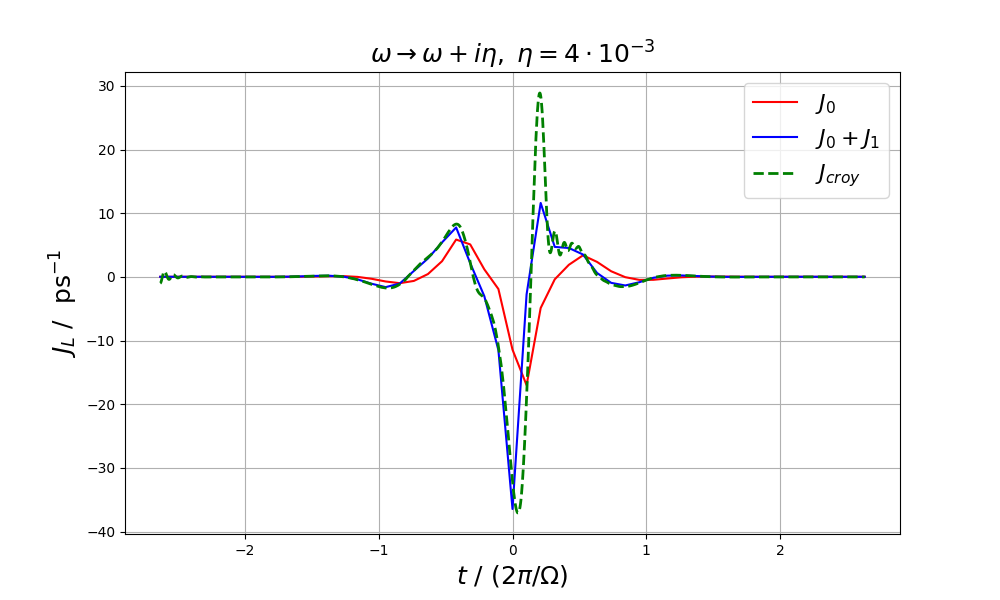

In [89]:
def Fermi(eps): #fermi-dirac distribution. eps is the energy measured relative to the chemical potential.
    return exp(-eps/Temperature)/(1+exp(-eps/Temperature))
def f_L(eps): #fermi functions for left and right leads in case they have different chemical potentials.
    return Fermi(eps-mu_L)
def f_R(eps):
    return Fermi(eps-mu_R)
#Numerical parameters
#Time & frequency parameters. Matrix (index) structure of variables will be [T,omega]
Tmin=-200
Tmax=200#2*np.pi/Omega
N_timesteps=51

omega_max=5
omega_min=-5
N_omega = 1500 + 1 #at low temperature, a large amount of frequency points is required for convergence of the
#exact expression. Much fewer points are necessary for convergence of the time-separated KB equations.
print('dw =',(omega_max-omega_min)/(N_omega-1))

#N_bessel_functions=50
N_Fermi_poles = 25
NL = 1
Lorentz_Width=1

def get_integration_var(N_int,lower_lim = 0, upper_lim = 1):
    x,w = leggauss(N_int)
    x = (x + 1)/2*(upper_lim-lower_lim) + lower_lim
    w *= (upper_lim - lower_lim)/2
    return x,w
#Croy parameters
tx = 2
t_dev =  1
t_elec = 20

lat_const = 2.5
lineWB = np.linspace(0.0, 0.0, 1) + 1j * 1e-2
lineNL = np.linspace(-15 , 15, 400)  + 1j*1e-2

line = lineWB
line = np.vstack((line,line))

geom_dev   = sisl.geom.sc(lat_const, 'H').tile(tx+2, 0)
geom_ep    = sisl.geom.sc(lat_const, 'H').tile(1, 0).move(np.array([lat_const * (tx+1), 0, 0]))
geom_em    = sisl.geom.sc(lat_const, 'H').tile(1, 0)

geom_dev   = geom_dev.add_vacuum(10,1).add_vacuum(10,2).add_vacuum(10,0)
geom_em    = geom_em. add_vacuum(10,1).add_vacuum(10,2)
geom_ep    = geom_ep. add_vacuum(10,1).add_vacuum(10,2)



Test = TD_Transport([geom_em,geom_ep], geom_dev, kT_i = [Temperature, Temperature], mu_i = [mu_L, mu_R])
Test.Make_Contour(line, N_Fermi_poles , pole_mode = 'JieHu2011')

Test.Electrodes( semi_infs = ['-a1', '+a1'] )
Test.make_device(
            elec_inds = [[0],[tx+1]],
            Print= False)

elec = sisl.Hamiltonian(sisl.geom.sc(lat_const, sisl.Atom(1, R= 3.0)).add_vacuum(10,1).add_vacuum(10,2))
elec.construct([[0.1, lat_const * 1.1], 
                [0  , t_elec             ]])

Test.run_electrodes(fois_gras_H = [elec, elec])

dev_H = sisl.Hamiltonian(sisl.geom.sc(lat_const, sisl.Atom(1, R= 3.0)).tile(tx+2,0).add_vacuum(10,1).add_vacuum(10,2).add_vacuum(10,0))
dev_H.construct([[0.1, lat_const * 1.1], 
                  [0,   1              ] ])

dev_H[0,1]        =  5**0.5
dev_H[1,0]        =  5**0.5
dev_H[tx+1,tx]  =  5**0.5
dev_H[tx,tx+1]  =  5**0.5
dev_H[2,2] = 1/2
dev_H[1,1] = -1/2
#
#eps = 1e-8
#dev_H[1,2] = eps
#dev_H[2,1] = eps
#dev_H[2,3] = eps
#dev_H[3,2] = eps
Test.run_device(fois_gras_H = dev_H)
Test.read_data()


min_tol  = -0.0*np.ones(NL)
min_tol1 =  min_tol.copy()
min_tol2 =  min_tol.copy()

def run_mini(its):
    Test.Fit(fact = 1.0, Fallback_W = Lorentz_Width, NumL = NL,
          fit_mode      = 'all',
          force_PSD     = True,
          force_PSD_tol = [min_tol1, min_tol2],
          use_analytical_jac = True,
          min_method = 'SLSQP',
          ebounds = (-5, 5),
          wbounds = (0.01, 0.8),
          gbounds = (None, None),
          tol = -1,
          options = {'disp':True,'maxiter':its, 
                     'gtol':1e-10,
                     'ftol':1e-10,
                     'iprint':1
                     },
          fit_real_part = False,
          specific_bounds = None,#[{(0 ,2) :[(0.1, 0.11), (4,5)]}, {(0 ,5) :[(-0.1, 0.1), (4,5)]}], 
          alpha_PO = 0.01, 
          )

run_mini(1)

Test.diagonalise()
Test.get_propagation_quantities()
Test.get_dense_matrices_purenp(1e-8)
Test.Check_input_to_ODE(loose_fermi = True)
f     = Test.make_f_purenp()
sig   = Test.sigma
psi   = Test.Psi_vec
croy_omega = Test.omegas

# In[]

#Vmax = 1.5

def dH(t,sigma):
    A = np.zeros(sigma.shape, dtype = np.complex128)
    #A[0,0,0] = +Vmax/2 * box_pulse(t, 20, 1, 1)
    #A[0,1,1] = -Vmax/2 * box_pulse(t, 20, 1, 1)
    A[0,0,0] = Delta[0,0] * Vbias(t)
    A[0,1,1] = Delta[1,1] * Vbias(t)#Delta[1,1] * Vbias(t)
    return A

def delta(t,a):
    if  a == 0:
        #return +Vmax * box_pulse(t, 20, 1, 1)
        return Delta_L * Vbias(t)
    if  a == 1:
        return Delta_R * Vbias(t)
#Time-scale separation

T=np.linspace(Tmin,Tmax,N_timesteps).reshape(N_timesteps,1,1,1)
omega_params = [omega_min, omega_max, N_omega]

#Psi_0 = 2*Delta/Omega*np.cos(Omega*T)

#Single-level device hamiltonian
#H0 = np.array(epsilon).reshape(1,1,1,1)
#V=1
#H0 = epsilon + np.array([[0,V],[V,0]])
H0 = Test.Hdense[0,0]
print(H0)
print('temperature',Temperature)
#H_d_dT = Delta*Vbias_dT(T)

D = timescale(T,omega_params,Delta_L=Delta_L,Delta_R=Delta_R,
              Delta=Delta,Vbias=Vbias,Vbias_dT = Vbias_dT,Vbias_int = Vbias_int,use_aux_modes=False,eta=0)
#eta=4e-3
D.get_physical_params(Test)
omega = D.omega
t1=time.time()
D.get_Lorentz_and_Fermi_params(Test)
#assert 1==0
J0,J1 = D.calc_current(T,omega,side='left')
t0=time.time()
print('Calculating current without aux mode took %.3f seconds'%(t0-t1))

t1=time.time()
t, d = AdaptiveRK4( f, sig, psi, croy_omega, 1e-12,  Tmin-15, Tmax,  dH, delta, Test.Ixi, 0.1, fixed_mode = False,                          name = 'DQD')
t0=time.time()
print('Propagating current with RK45 took %.3f seconds'%(t0-t1))
tcroy = t[t>Tmin]
Jcroy_L = np.array(d['current_left'])
Jcroy_L = Jcroy_L[t>Tmin]
to_pseconds = scipy.constants.hbar / scipy.constants.e * 1e12
to_THz = 1/to_pseconds
omega_to_THz = 1/(2*np.pi)*to_THz
Omega = 2*np.pi*freq
plt.figure(figsize=(10,6))
plt.plot(T.flatten()/(2*np.pi/Omega),J0/to_pseconds,color='r',label='$J_0$')
plt.plot(T.flatten()/(2*np.pi/Omega),(J0+J1)/to_pseconds,color='b',label='$J_0 + J_1$')
#plt.plot(T.flatten()/(2*np.pi/Omega),J0_L_eta/to_pseconds,color='r',label='$J_{0\eta}$',linestyle='dotted')
#plt.plot(T.flatten()/(2*np.pi/Omega),(J0_L_eta+J1_L_eta)/to_pseconds,color='b',label='$J_{0\eta} + J_{1\eta}$',linestyle='dotted')
#plt.plot(T.flatten(),J0+J1+J2,color='g')
#plt.plot(T.flatten(),J0+J1+J2+J3,color='orange')
#plt.plot(T.flatten()/(2*np.pi/Omega),40*Vbias(T.flatten()),alpha=0.5,linestyle='dashed',label='$V_{ext}$ (AC, 20 THz)')
#plt.plot(T.flatten(),J_exact,color='g')
plt.plot(tcroy/(2*np.pi/Omega),Jcroy_L/to_pseconds,color='green',linestyle='dashed',label='$J_{croy}$',linewidth=2)
plt.ylabel(r'$J_L$ /  ps$^{-1} $',fontsize=18)
plt.xlabel(r'$t \ / \ (2\pi/\Omega)$',fontsize=18)
plt.title(r'$\omega \rightarrow \omega + i \eta, \ \eta = 4\cdot 10^{-3}$',fontsize=18)
plt.legend(fontsize=16)
plt.grid()
#plt.savefig('current with and without eta.svg')


<IPython.core.display.Javascript object>


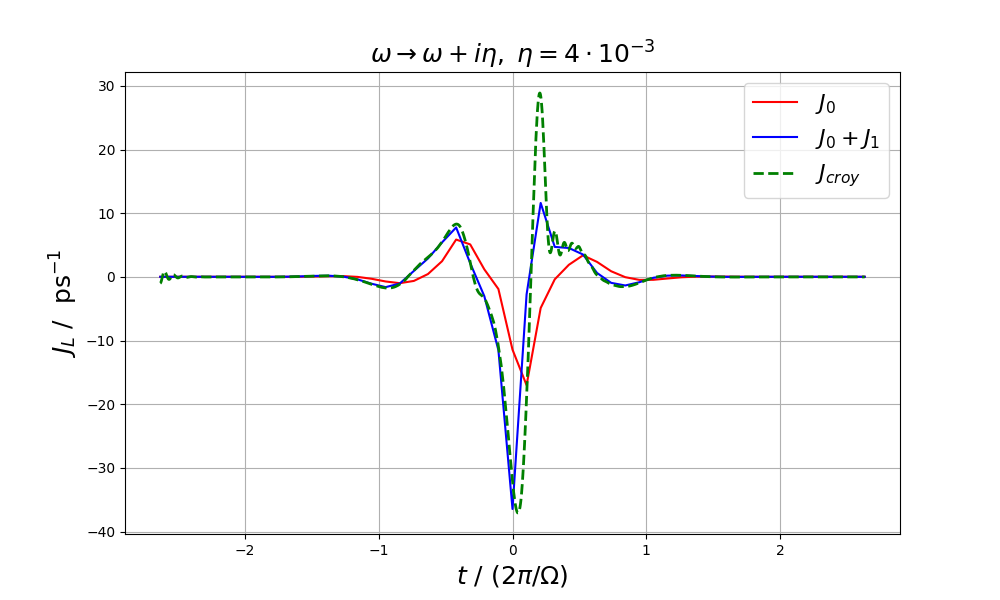

In [90]:
plt.figure(figsize=(10,6))
plt.plot(T.flatten()/(2*np.pi/Omega),J0/to_pseconds,color='r',label='$J_0$')
plt.plot(T.flatten()/(2*np.pi/Omega),(J0+J1)/to_pseconds,color='b',label='$J_0 + J_1$')
#plt.plot(T.flatten()/(2*np.pi/Omega),J0_L_eta/to_pseconds,color='r',label='$J_{0\eta}$',linestyle='dotted')
#plt.plot(T.flatten()/(2*np.pi/Omega),(J0_L_eta+J1_L_eta)/to_pseconds,color='b',label='$J_{0\eta} + J_{1\eta}$',linestyle='dotted')
#plt.plot(T.flatten(),J0+J1+J2,color='g')
#plt.plot(T.flatten(),J0+J1+J2+J3,color='orange')
#plt.plot(T.flatten()/(2*np.pi/Omega),40*Vbias(T.flatten()),alpha=0.5,linestyle='dashed',label='$V_{ext}$ (AC, 20 THz)')
#plt.plot(T.flatten(),J_exact,color='g')
plt.plot(tcroy/(2*np.pi/Omega),Jcroy_L/to_pseconds,color='green',linestyle='dashed',label='$J_{croy}$',linewidth=2)
plt.ylabel(r'$J_L$ /  ps$^{-1} $',fontsize=18)
plt.xlabel(r'$t \ / \ (2\pi/\Omega)$',fontsize=18)
plt.title(r'$\omega \rightarrow \omega + i \eta, \ \eta = 4\cdot 10^{-3}$',fontsize=18)
plt.legend(fontsize=16)
plt.grid()

In [131]:
use_aux_modes = True
alpha='R'
omega=D.omega
T=D.T
extension_length = 2000
#def calc_Sigma_less(T=None,omega=None,alpha='L',extension_length=1000): #new one
if np.all(T==None):
    T=D.T
    #print('calc_Sigma_less: set T = D.T',flush=True)
if np.all(omega==None):
    omega = D.omega
    set_self_tau = 1
else: 
    set_self_tau = 0

if alpha=='L':
    f = D.f_L
    Gamma = D.Gamma_L
    potential = D.potential_L
    Lorentz_params = D.Lorentz_params_L
    coupling_index = D.coupling_index_L
    Delta_alpha = D.Delta_L
else:
    f = D.f_R
    Gamma = D.Gamma_R
    potential = D.potential_R
    Lorentz_params = D.Lorentz_params_R
    coupling_index = D.coupling_index_R
    Delta_alpha = D.Delta_R
if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
    Gamma_mat = Gamma
    Gamma = lambda x : Gamma_mat
    #print('WBL! Gamma was not callable')

T=np.array(T).reshape(-1,1,1,1)
omega=np.array(omega).reshape(-1,1,1)   
exp = np.exp
omega_min = omega.min()
omega_max = omega.max()
dw = (omega_max - omega_min)/(np.size(omega)-1)
#if extension_length < np.size(omega)/4:
#    extension_length = int(np.size(omega)/4)
#extend internal arrays by extension_length. this is useful if the specified range of integration does not include the entire support of the given functions.
extension = dw*np.linspace(1,extension_length,extension_length)
w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
w=w.reshape(1,-1,1,1)
#print('w[extension_length] == omega_min? w[ext_len]==', w[extension_length],'omega_min ==',omega_min)
#dw_taumax = 2*np.(Tmax - Tmin)
#Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
V_min = - V_max
max_freq_signal = (V_max - V_min)*5
max_freq_fermi = np.max(np.abs(D.Fermi_params[0]))
max_freq_Lorentz =np.max(np.abs(Lorentz_params[0]))
max_freq = max(max_freq_signal,max_freq_fermi,max_freq_Lorentz)
dtau_max = 1/(2.1*max_freq)
min_domain_length = 2*np.pi/dtau_max
domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
N1 = np.ceil(domain_length/dw) 
#tau_max_for_entire_domain = 2*(Tmax - Tmin)
#N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
#N3=max(N1,N2)
N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
if N>1e5:
    print("N in calc_Sigma_less larger than 100k!")
#x = domain_length/N * np.arange(N) #generate x variable for FFT.
x = dw*np.arange(N)
domain_length= x.max() * N/(N-1)
x = x.reshape(1,-1,1,1) #shape to proper size
dtau = 2*np.pi/domain_length
tau = dtau*np.arange(N) #generate tau variable for FFT
tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
#calculate expint
if D.Vbias_int is None:
    expint = np.exp(-1j*D.expint3(T,tau,alpha))
else:
    expint = np.exp(-1j*Delta_alpha*(D.Vbias_int(T+tau/2) - D.Vbias_int(T-tau/2)))

expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
Sigma_less = np.zeros((np.size(T),np.size(omega),D.device_dim,D.device_dim),dtype=np.complex128)
omega_index = slice(extension_length,(np.size(omega)+extension_length))
if not use_aux_modes:
    fermi = D.Fermi_pade(x+w.min(),alpha)#f(x+w.min())
    Gam = Gamma(x+w.min())

for i in range(D.device_dim):
    for j in range(D.device_dim):
        if coupling_index[i,j]:
            if use_aux_modes:
                #tau_centralized = tau - np.mean(tau)
                fermi_int_residues = lambda E : Gamma(E,i,j)*exp(-1j*(E)*tau)
                Lorentz_int_residues = lambda E : D.Fermi_pade(E,alpha)*exp(-1j*(E)*tau)#f(E)*exp(-1j*(E)*taup)#

                Lor_poles, Lor_res = Lorentz_params
                Lorentz_params_ij = [Lor_poles,Lor_res[:,i,j]]
                fermi_int = D.int_residues2(fermi_int_residues,D.Fermi_params,halfplane='lower')
                Lorentz_int = D.int_residues2(Lorentz_int_residues,Lorentz_params_ij,halfplane='lower')
                Sigma_less_forward = (fermi_int + Lorentz_int).reshape(1,-1)/(2*np.pi)
                Sigma_less_forward[:,0] /=2
                Sigma_less_forward = Sigma_less_forward * exp(1j*w.min()*tau[:,:,0,0])
                Sigma_less_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)

                fermi_residues_Sigzero = lambda E : (Gamma(E,i,j)/(omega-E))
                Lorentz_residues_Sigzero = lambda E : (D.Fermi_pade(E,alpha)/(omega-E))
                fermi_int_Sigzero = D.int_residues2(fermi_residues_Sigzero,D.Fermi_params,halfplane='lower').reshape(1,-1)
                Lorentz_int_Sigzero = D.int_residues2(Lorentz_residues_Sigzero,Lorentz_params_ij,halfplane='lower').reshape(1,-1)
                #fg = (D.Fermi_pade(omega,alpha)*Gamma(omega,i,j)).reshape(1,-1)
                Hilbert_trans = (fermi_int_Sigzero + Lorentz_int_Sigzero)# + 1j*np.pi*fg
                #Hilbert_trans = 0
                Sigma_zero = 2j*np.real(expPhi*(1j*Hilbert_trans ))/(2*np.pi) #+ 1*np.pi*fg)/(2*np.pi))

                Sigma_less[:,:,i,j] = 2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
                #Sigma_zero = np.real()
            else:

                #forward transform (energy integral)
                integrand = Gam[:,:,i,j]*fermi[:,:,0,0]
                #integrand[:,0] /= 2
                #integrand[:,-1] /= 2
                Sigma_less_forward = domain_length/(2*np.pi*N)*D.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #the last factor is only needed if the energy integral does not start at omega_min
                #Sigma_less_forward[:,0] /= 2
                #Sigma_less_forward[:,-1] /= 2
                #backward transform (tau integral)
                #Sigma_less_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi) * Sigma_less_forward,axis=1)
                Sigma_less_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)
                fg=Gam[:,omega_index,i,j]*fermi[:,omega_index,0,0]
                Sigma_zero = 2j*np.real(expPhi*(fg/2 + 1j/2*D.hilbert(fg)))

                #Sigma_less_backward += expPhi*Gam[:,:,i,j]*fermi[:,:,0,0]/2 #divide by 2 because next line multiplies by 2
                #Sigma_less[:,:,i,j] = 2j * np.real(Sigma_less_backward[:,extension_length:(np.size(omega)+extension_length)])
                Sigma_less[:,:,i,j] =   2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
    #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

#return Sigma_less# + 1j*D.eta*np.identity(D.device_dim)
if use_aux_modes:
    Sigma_aux = Sigma_less[:,:,1,1]
    Sigma_zero_aux = Sigma_zero
    Sigma_less_forward_aux = Sigma_less_forward
else:
    Sigma_fft = Sigma_less[:,:,1,1]
    Sigma_zero_fft = Sigma_zero
    Sigma_less_forward_fft = Sigma_less_forward

N in calc_Sigma_less larger than 100k!


<IPython.core.display.Javascript object>


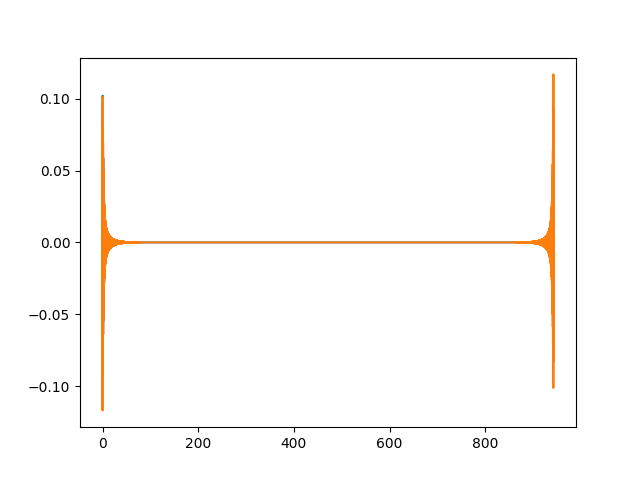

In [132]:
plt.figure()
Sigma_less_forward_fft_shifted = Sigma_less_forward_fft #* exp(-1j*w.min()*tau[:,:,0,0])
plt.plot(tau.flatten(),np.imag(Sigma_less_forward_aux[0]))
plt.plot(tau.flatten(),np.imag(Sigma_less_forward_fft_shifted[0]))

<IPython.core.display.Javascript object>


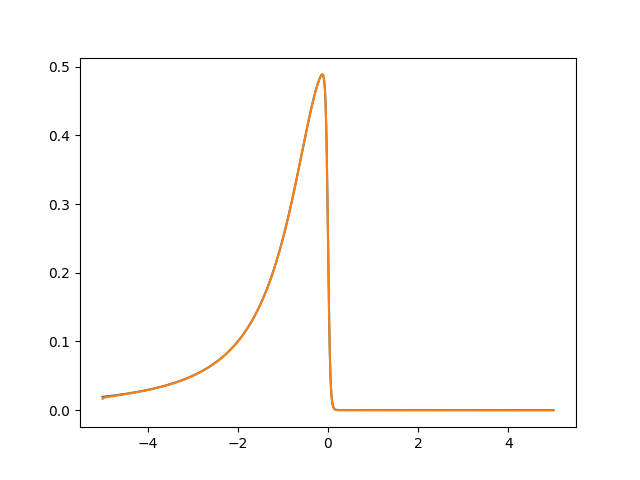

In [133]:
plt.figure()
plt.plot(omega.flatten(),np.imag(Sigma_aux[0]))
plt.plot(omega.flatten(),np.imag(Sigma_fft[0]))

<IPython.core.display.Javascript object>


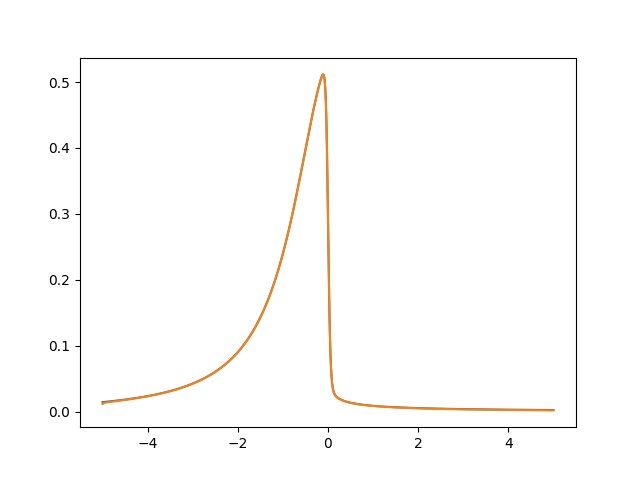

In [134]:
plt.figure()
plt.plot(omega.flatten(),np.imag(Sigma_zero_aux[0]))
plt.plot(omega.flatten(),np.imag(Sigma_zero_fft[0]))

In [93]:
D.Lorentz_params_R

(array([[[0.+1.j]],
 
        [[0.-1.j]]]),
 array([[[ 0.+0.j       ,  0.+0.j       ],
         [ 0.+0.j       ,  0.-0.2499375j]],
 
        [[-0.+0.j       , -0.+0.j       ],
         [-0.+0.j       , -0.+0.2499375j]]]))

In [94]:
D.coupling_index_R

array([[False, False],
       [False,  True]])

<IPython.core.display.Javascript object>


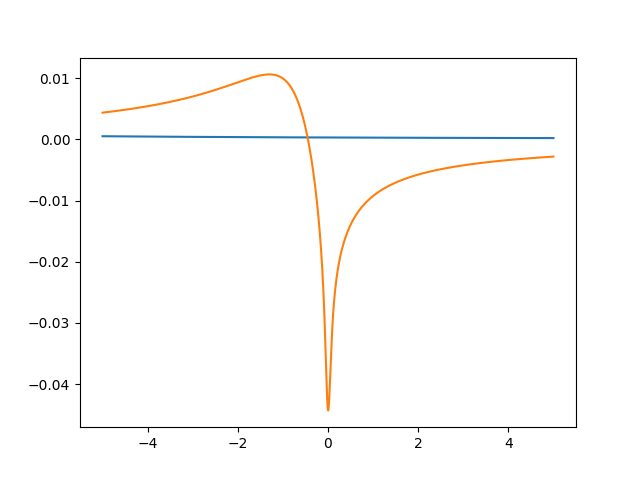

In [95]:
plt.figure()

plt.plot(D.omega.flatten(),Sigma_aux[0].imag - Sigma_zero_aux[0].imag)
plt.plot(D.omega.flatten(),Sigma_fft[0].imag - Sigma_zero_fft[0].imag)

In [ ]:
w.min()

In [ ]:
plt.figure()

plt.plot(x.flatten(),(np.fft.fftshift(Sigma_less_forward_fft[0,:]*exp(1j*(-w.min())*tau[0,:,0,0]))).imag)
plt.plot(x.flatten(),np.fft.fftshift(Sigma_less_forward_aux[0,:].imag))#*exp(1j*(-w.min())*tau[0,:,0,0]))

In [ ]:
plt.figure()
plt.plot(w.flatten(),Gamma(w)[:,1,1])

In [ ]:
Fourier_Gamma = D.int_residues2(lambda t : exp(-1j*t*tau),Lorentz_params,'lower')[0,:,1,1]
plt.figure()
plt.plot(tau.flatten(),Fourier_Gamma)
plt.plot(tau.flatten(),np.pi/2*np.exp(-tau.flatten()))
plt.xlim([0,10])

In [ ]:
#use_aux_modes=True
#Sigma_aux = calc_Sigma_less(alpha='R')[:,:,1,1].imag
#use_aux_modes=False
#Sigma_fft = calc_Sigma_less(alpha='R')[:,:,1,1].imag

In [ ]:
%matplotlib notebook
plt.figure()
T0i=0
w = D.omega.flatten()
plt.plot(w,Sigma_zero_aux[T0i,:].imag)
plt.plot(w,Sigma_zero_fft[T0i,:].imag)
#plt.plot(w,Sigma_aux[0],linestyle='dashed')
#plt.plot(w,Sigma_fft[0],linestyle='dashed')
#plt.plot(w,Sigma_zero.imag[T0i])

In [6]:
def calc_Sigma_R(T=None,omega=None,alpha='L',extension_length=300): #new one
    if np.all(T==None):
        T=D.T
        #print('calc_Sigma_less: set T = D.T',flush=True)
    if np.all(omega==None):
        omega = D.omega
        set_self_tau = 1
    else: 
        set_self_tau = 0

    if alpha=='L':
        Gamma = D.Gamma_L
        potential = D.potential_L
        Lorentz_params = D.Lorentz_params_L
        coupling_index = D.coupling_index_L
        Delta_alpha = D.Delta_L
    else:
        Gamma = D.Gamma_R
        potential = D.potential_R
        Lorentz_params = D.Lorentz_params_R
        coupling_index = D.coupling_index_R
        Delta_alpha = D.Delta_R
    if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
        Gamma_mat = Gamma
        Gamma = lambda x : Gamma_mat
        #print('WBL! Gamma was not callable')

    T=np.array(T).reshape(-1,1,1,1)
    omega=np.array(omega).reshape(-1,1,1)   
    exp = np.exp
    omega_min = omega.min()
    omega_max = omega.max()
    dw = (omega_max - omega_min)/(np.size(omega)-1)
    #extension_length = 50
    #if extension_length < np.size(omega)/4:
    #    extension_length = int(np.size(omega)/4)
    #print('extending internal arrays by ',extension_length)
    extension = dw*np.linspace(1,extension_length,extension_length)
    w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
    w=w.reshape(-1,1,1)
    if np.array_equal(w,omega):
        print('w==omega, extension_length ==', extension_length)

    #w=omega
    #dw_taumax = 2*np.(Tmax - Tmin)
    #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
    V_min = - V_max
    max_freq = V_max - V_min
    dtau_max = 1/(2*max_freq)
    min_domain_length = 2*np.pi/dtau_max
    domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
    N1 = np.ceil(domain_length/dw) 
    #tau_max_for_entire_domain = 2*(Tmax - Tmin)
    #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
    #N3=max(N1,N2)
    N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
    #x = domain_length/N * np.arange(N) #generate x variable for FFT.
    x = dw*np.arange(N)
    x = x.reshape(1,-1,1,1) #shape to proper size
    domain_length = x.max() * N/(N-1)
    dtau = 2*np.pi/domain_length
    tau = dtau*np.arange(N) #generate tau variable for FFT
    tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
    #calculate expint
    if D.Vbias_int is None:
        expint = np.exp(-1j*D.expint3(T,tau,alpha))
    else:
        expint = np.exp(-1j*Delta_alpha*(D.Vbias_int(T+tau/2) - D.Vbias_int(T-tau/2)))
    expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
    Sigma_R = np.zeros((np.size(T),np.size(omega),D.device_dim,D.device_dim),dtype=np.complex128)
    #extension_length=100
    if not use_aux_modes:
        Gam = Gamma(x+w.min())
    omega_index = slice(extension_length,(np.size(omega)+extension_length))
    for i in range(D.device_dim):
        for j in range(D.device_dim):
            if coupling_index[i,j]:
                if use_aux_modes:
                    Lorentz_int_residues = lambda E : exp(-1j*(E)*tau)#f(E)*exp(-1j*(E)*taup)#
                    Lor_poles, Lor_res = Lorentz_params
                    Lorentz_params_ij = [Lor_poles,Lor_res[:,i,j]]
                    Lorentz_int = D.int_residues2(Lorentz_int_residues,Lorentz_params_ij,halfplane='lower')
                    Sigma_R_forward = Lorentz_int.reshape(1,-1)/(2*np.pi)
                    Sigma_R_forward = Sigma_R_forward * exp(1j*w.min()*tau[:,:,0,0])
                    #Sigma_R_forward[:,0] /= 2
                    #Sigma_R_forward[:,-1] /= 2
                    Sigma_R_backward = -1j*tau.max() * D.ifft((expint[:,:,0,0]-expPhi)* Sigma_R_forward,axis=1)
                    Lorentz_residues_Sigzero = lambda E : 1/(omega-E)
                    Hilbert_trans = D.int_residues2(Lorentz_residues_Sigzero,Lorentz_params_ij,halfplane='lower').reshape(1,-1)
                    Sigma_zero = -1j*expPhi*(0*Gamma(omega,i,j).reshape(1,-1)/2 + 1j*Hilbert_trans/(2*np.pi) ).reshape(1,-1)
                    Sigma_R[:,:,i,j] =  Sigma_R_backward[:,omega_index] +Sigma_zero
                else:
                #forward transform (energy integral)
                    integrand = Gam[:,:,i,j]
                    #integrand[:,0] /= 2
                    #integrand[:,-1] /= 2
                    Sigma_R_forward = domain_length/(2*np.pi*N)*D.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #this factor is only needed if the energy integral does not start at omega_min
                    #Sigma_R_forward[:,0] /= 2
                    #Sigma_R_forward[:,-1] /= 2
                    #backward transform (tau integral)
                    Sigma_R_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi) * Sigma_R_forward,axis=1)

                    Sigma_R_backward = -1j*Sigma_R_backward[:,omega_index]
                    #print('Sigma_R_backward_shape',Sigma_R_backward.shape)
                    Sigma_R[:,:,i,j] =   Sigma_R_backward - expPhi*(1j*Gam[:,omega_index,i,j]/2 - 1/2*D.hilbert(Gam[:,omega_index,i,j],axis=1))#
    #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

    #Sigma_less = 1j*D.ifft(expint*Sigma_less_integrand,axis=1)
    #Sigma_less = Sigma_less[:,extension_length:-extension_length]
    return Sigma_R #- 1j*D.eta*np.identity(D.device_dim)


In [7]:
D.eta = 0
D.get_physical_params(Test)
D.use_aux_modes=True
Sigma_aux = D.calc_Sigma_less(alpha='R')[:,:,1,1]
D.use_aux_modes=False
Sigma_fft = D.calc_Sigma_less(alpha='R')[:,:,1,1]

Running get_physical_params. Remember Delta_R, Delta_L, Delta and Vbias must be specified manually


<IPython.core.display.Javascript object>


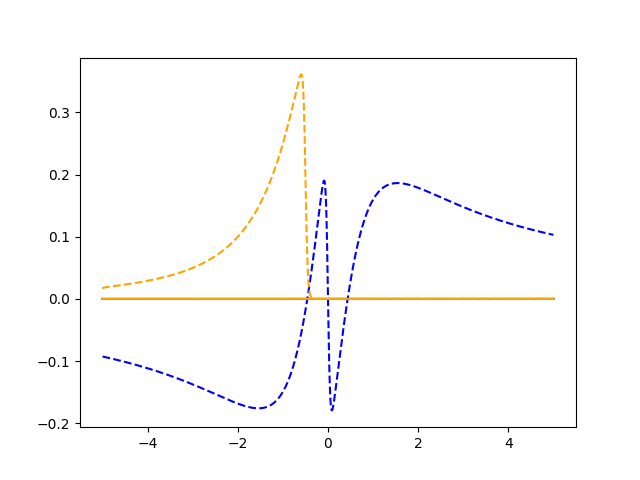

In [8]:
plt.figure()
T0i=10
w = D.omega.flatten()
plt.plot(w,Sigma_aux[T0i].real,color='blue')
plt.plot(w,Sigma_aux[T0i].imag,color='blue',linestyle='dashed')
plt.plot(w,Sigma_fft[T0i].real,color='orange')
plt.plot(w,Sigma_fft[T0i].imag,color='orange',linestyle='dashed')

In [10]:
def calc_Sigma_less(T=None,omega=None,alpha='L',extension_length=200): #new one with aux modes
    if np.all(T==None):
        T=D.T
        #print('calc_Sigma_less: set T = D.T',flush=True)
    if np.all(omega==None):
        omega = D.omega
        set_self_tau = 1
    else: 
        set_self_tau = 0

    if alpha=='L':
        f = D.f_L
        Gamma = D.Gamma_L
        potential = D.potential_L
        Lorentz_params = D.Lorentz_params_L
        coupling_index = D.coupling_index_L
        Delta_alpha = D.Delta_L
    else:
        f = D.f_R
        Gamma = D.Gamma_R
        potential = D.potential_R
        Lorentz_params = D.Lorentz_params_R
        coupling_index = D.coupling_index_R
        Delta_alpha = D.Delta_R
    if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
        Gamma_mat = Gamma
        Gamma = lambda x : Gamma_mat
        #print('WBL! Gamma was not callable')

    T=np.array(T).reshape(-1,1,1,1)
    omega=np.array(omega).reshape(-1,1,1)   
    exp = np.exp
    omega_min = omega.min()
    omega_max = omega.max()
    dw = (omega_max - omega_min)/(np.size(omega)-1)
    #if extension_length < np.size(omega)/4:
    #    extension_length = int(np.size(omega)/4)
    #extend internal arrays by extension_length. this is useful if the specified range of integration does not include the entire support of the given functions.
    extension = dw*np.linspace(1,extension_length,extension_length)
    w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
    w=w.reshape(-1,1,1)
    #print('w[extension_length] == omega_min? w[ext_len]==', w[extension_length],'omega_min ==',omega_min)
    #dw_taumax = 2*np.(Tmax - Tmin)
    #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
    V_min = - V_max
    max_freq = V_max - V_min
    dtau_max = 1/(2*max_freq)
    min_domain_length = 2*np.pi/dtau_max
    domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
    N1 = np.ceil(domain_length/dw) 
    #tau_max_for_entire_domain = 2*(Tmax - Tmin)
    #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
    #N3=max(N1,N2)
    N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
    if N>1e5:
        print("N in calc_Sigma_less larger than 100k!")
    #x = domain_length/N * np.arange(N) #generate x variable for FFT.
    x = dw*np.arange(N)
    domain_length= x.max() * N/(N-1)
    x = x.reshape(1,-1,1,1) #shape to proper size
    dtau = 2*np.pi/domain_length
    tau = dtau*np.arange(N) #generate tau variable for FFT
    tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
    #calculate expint
    if D.Vbias_int is None:
        expint = np.exp(-1j*D.expint3(T,tau,alpha))
    else:
        expint = np.exp(-1j*Delta_alpha*(D.Vbias_int(T+tau/2) - D.Vbias_int(T-tau/2)))

    expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
    Sigma_less = np.zeros((np.size(T),np.size(omega),D.device_dim,D.device_dim),dtype=np.complex128)
    omega_index = slice(extension_length,(np.size(omega)+extension_length))
    if not D.use_aux_modes:
        fermi = f(x+w.min())
        Gam = Gamma(x+w.min())

    for i in range(D.device_dim):
        for j in range(D.device_dim):
            if coupling_index[i,j]:
                if D.use_aux_modes:
                    fermi_int_residues = lambda E : Gamma(E,i,j)*exp(-1j*(E)*tau)
                    Lorentz_int_residues = lambda E : D.Fermi_pade(E,alpha)*exp(-1j*(E)*tau)#f(E)*exp(-1j*(E)*taup)#

                    Lor_poles, Lor_res = Lorentz_params
                    Lorentz_params_ij = [Lor_poles,Lor_res[:,i,j]]
                    fermi_int = D.int_residues2(fermi_int_residues,D.Fermi_params,halfplane='lower')
                    Lorentz_int = D.int_residues2(Lorentz_int_residues,Lorentz_params_ij,halfplane='lower')
                    Sigma_less_forward = (fermi_int + Lorentz_int).reshape(1,-1)/(2*np.pi)
                    Sigma_less_forward = Sigma_less_forward * exp(1j*w.min()*tau[:,:,0,0])
                    Sigma_less_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)
                    fermi_residues_Sigzero = lambda E : Gamma(E,i,j)/(omega-E)
                    Lorentz_residues_Sigzero = lambda E : D.Fermi_pade(E,alpha)/(omega-E)
                    fermi_int_Sigzero = D.int_residues2(fermi_residues_Sigzero,D.Fermi_params,halfplane='lower').reshape(1,-1)
                    Lorentz_int_Sigzero = D.int_residues2(Lorentz_residues_Sigzero,Lorentz_params_ij,halfplane='lower').reshape(1,-1)
                    #fg = (D.Fermi_pade(omega,alpha)*Gamma(omega,i,j)).reshape(1,-1)
                    Hilbert_trans = (fermi_int_Sigzero + Lorentz_int_Sigzero) #- 1j*np.pi*fg

                    Sigma_zero = 2j*np.real(expPhi*(1j*Hilbert_trans)/(2*np.pi))

                    Sigma_less[:,:,i,j] = 2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
                    #Sigma_zero = np.real()
                else:

                    #forward transform (energy integral)
                    integrand = Gam[:,:,i,j]*fermi[:,:,0,0]
                    #integrand[:,0] /= 2
                    #integrand[:,-1] /= 2
                    Sigma_less_forward = domain_length/(2*np.pi*N)*D.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #the last factor is only needed if the energy integral does not start at omega_min
                    #Sigma_less_forward[:,0] /= 2
                    #Sigma_less_forward[:,-1] /= 2
                    #backward transform (tau integral)
                    #Sigma_less_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi) * Sigma_less_forward,axis=1)
                    Sigma_less_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi)* Sigma_less_forward,axis=1)
                    fg=Gam[:,omega_index,i,j]*fermi[:,omega_index,0,0]
                    Sigma_zero = 2j*np.real(expPhi*(fg/2 + 1j/2*D.hilbert(fg)))

                    #Sigma_less_backward += expPhi*Gam[:,:,i,j]*fermi[:,:,0,0]/2 #divide by 2 because next line multiplies by 2
                    #Sigma_less[:,:,i,j] = 2j * np.real(Sigma_less_backward[:,extension_length:(np.size(omega)+extension_length)])
                    Sigma_less[:,:,i,j] =   2j*np.real(Sigma_less_backward[:,omega_index]) + Sigma_zero
        #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

    return Sigma_less# + 1j*D.eta*np.identity(D.device_dim)

def calc_Sigma_R(T=None,omega=None,alpha='L',extension_length=300): #new one
    if np.all(T==None):
        T=D.T
        #print('calc_Sigma_less: set T = D.T',flush=True)
    if np.all(omega==None):
        omega = D.omega
        set_self_tau = 1
    else: 
        set_self_tau = 0

    if alpha=='L':
        Gamma = D.Gamma_L
        potential = D.potential_L
        Lorentz_params = D.Lorentz_params_L
        coupling_index = D.coupling_index_L
        Delta_alpha = D.Delta_L
    else:
        Gamma = D.Gamma_R
        potential = D.potential_R
        Lorentz_params = D.Lorentz_params_R
        coupling_index = D.coupling_index_R
        Delta_alpha = D.Delta_R
    if not callable(Gamma): #make gamma callable even in the WBL to make the syntax the same in every case.
        Gamma_mat = Gamma
        Gamma = lambda x : Gamma_mat
        #print('WBL! Gamma was not callable')

    T=np.array(T).reshape(-1,1,1,1)
    omega=np.array(omega).reshape(-1,1,1)   
    exp = np.exp
    omega_min = omega.min()
    omega_max = omega.max()
    dw = (omega_max - omega_min)/(np.size(omega)-1)
    #extension_length = 50
    #if extension_length < np.size(omega)/4:
    #    extension_length = int(np.size(omega)/4)
    #print('extending internal arrays by ',extension_length)
    extension = dw*np.linspace(1,extension_length,extension_length)
    w = np.concatenate(((omega_min - np.flip(extension)),omega.flatten(),omega_max + extension))
    w=w.reshape(-1,1,1)
    if np.array_equal(w,omega):
        print('w==omega, extension_length ==', extension_length)

    #w=omega
    #dw_taumax = 2*np.(Tmax - Tmin)
    #Calculate range of integration needed for sufficiently fine tau sampling (dt = 2pi/(b-a)) and nyquist: 1/dt > 2*max freq
    V_min = - V_max
    max_freq = V_max - V_min
    dtau_max = 1/(2*max_freq)
    min_domain_length = 2*np.pi/dtau_max
    domain_length = max(w.max()-w.min(), min_domain_length) #We should at least include the entire range [omega_min, omega_max].
    N1 = np.ceil(domain_length/dw) 
    #tau_max_for_entire_domain = 2*(Tmax - Tmin)
    #N2 = np.ceil(tau_max_for_entire_domain/(2*np.pi)*domain_length + 1)
    #N3=max(N1,N2)
    N = int(2**np.ceil(np.log(N1)/np.log(2))) #Make N a power of two for most efficient FFT. do so in a way that cannot decrease the value of N.
    #x = domain_length/N * np.arange(N) #generate x variable for FFT.
    x = dw*np.arange(N)
    x = x.reshape(1,-1,1,1) #shape to proper size
    domain_length = x.max() * N/(N-1)
    dtau = 2*np.pi/domain_length
    tau = dtau*np.arange(N) #generate tau variable for FFT
    tau = tau.reshape(1,-1,1,1) #reshape for use in expint.
    #calculate expint
    if D.Vbias_int is None:
        expint = np.exp(-1j*D.expint3(T,tau,alpha))
    else:
        expint = np.exp(-1j*Delta_alpha*(D.Vbias_int(T+tau/2) - D.Vbias_int(T-tau/2)))
    expPhi = expint[0,-1,0,0] #choose largest value of tau - this is the integral of the pulse over its entire support.
    Sigma_R = np.zeros((np.size(T),np.size(omega),D.device_dim,D.device_dim),dtype=np.complex128)
    #extension_length=100
    if not D.use_aux_modes:
        Gam = Gamma(x+w.min())
    omega_index = slice(extension_length,(np.size(omega)+extension_length))
    for i in range(D.device_dim):
        for j in range(D.device_dim):
            if coupling_index[i,j]:
                if D.use_aux_modes:
                    Lorentz_int_residues = lambda E : exp(-1j*(E)*tau)#f(E)*exp(-1j*(E)*taup)#
                    Lor_poles, Lor_res = Lorentz_params
                    Lorentz_params_ij = [Lor_poles,Lor_res[:,i,j]]
                    Lorentz_int = D.int_residues2(Lorentz_int_residues,Lorentz_params_ij,halfplane='lower')
                    Sigma_R_forward = Lorentz_int.reshape(1,-1)/(2*np.pi)
                    Sigma_R_forward = Sigma_R_forward * exp(1j*w.min()*tau[:,:,0,0])
                    #Sigma_R_forward[:,0] /= 2
                    #Sigma_R_forward[:,-1] /= 2
                    Sigma_R_backward = -1j*tau.max() * D.ifft((expint[:,:,0,0]-expPhi)* Sigma_R_forward,axis=1)
                    Lorentz_residues_Sigzero = lambda E : 1/(omega-E)
                    Hilbert_trans = D.int_residues2(Lorentz_residues_Sigzero,Lorentz_params_ij,halfplane='lower').reshape(1,-1)
                    Sigma_zero = -1j*expPhi*(0*Gamma(omega,i,j).reshape(1,-1)/2 + 1j*Hilbert_trans/(2*np.pi) ).reshape(1,-1)
                    Sigma_R[:,:,i,j] =  Sigma_R_backward[:,omega_index] +Sigma_zero
                else:
                #forward transform (energy integral)
                    integrand = Gam[:,:,i,j]
                    #integrand[:,0] /= 2
                    #integrand[:,-1] /= 2
                    Sigma_R_forward = domain_length/(2*np.pi*N)*D.fft(integrand,axis=1)#*exp(-1j*(w.min()-omega_min)*tau[:,:,0,0]) #this factor is only needed if the energy integral does not start at omega_min
                    #Sigma_R_forward[:,0] /= 2
                    #Sigma_R_forward[:,-1] /= 2
                    #backward transform (tau integral)
                    Sigma_R_backward = tau.max() * D.ifft((expint[:,:,0,0]-expPhi) * Sigma_R_forward,axis=1)

                    Sigma_R_backward = -1j*Sigma_R_backward[:,omega_index]
                    #print('Sigma_R_backward_shape',Sigma_R_backward.shape)
                    Sigma_R[:,:,i,j] =   Sigma_R_backward - expPhi*(1j*Gam[:,omega_index,i,j]/2 - 1/2*D.hilbert(Gam[:,omega_index,i,j],axis=1))#
    #print('sigma_less: did not use aux mode! Finished in %.2f'%(t1-t0),flush=True)

    #Sigma_less = 1j*D.ifft(expint*Sigma_less_integrand,axis=1)
    #Sigma_less = Sigma_less[:,extension_length:-extension_length]
    return Sigma_R

In [97]:
D.Fermi_pade(0.25j,alpha='R')

(0.5+1.6902575031232687j)

In [108]:
D.f_R(0.25j) 

(-1.7294553233746671e-09+1.121311087271188e-09j)

In [102]:
D.Lorentz_params_R

(array([[[0.+1.j]],
 
        [[0.-1.j]]]),
 array([[[ 0.+0.j       ,  0.+0.j       ],
         [ 0.+0.j       ,  0.-0.2499375j]],
 
        [[-0.+0.j       , -0.+0.j       ],
         [-0.+0.j       , -0.+0.2499375j]]]))

In [103]:
Lorentz_params_ij

[array([[[0.+1.j]],
 
        [[0.-1.j]]]),
 array([ 0.-0.2499375j, -0.+0.2499375j])]